# Machine Learning Feature Importance Analysis: Game Effects on Pain

This notebook performs machine learning analyses to identify the most important features (game experience variables, personality traits, mindfulness) that predict pain intensity and unpleasantness ratings. The analysis uses SHAP (SHapley Additive exPlanations) values to understand feature importance and contributions to model predictions.

**Dependencies:** pandas, numpy, scikit-learn, xgboost, shap, pingouin, matplotlib, seaborn, tensorflow


In [2]:
# Install required packages (uncomment if needed)
# !pip install shap
# !pip install pingouin

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import shap
import os
import pingouin as pg
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Importing the data


In [4]:
df = pd.read_excel('GameData.xlsx')

# Show the first 5 rows of the DataFrame
print(df.head())

# Show the shape of the DataFrame (number of rows and columns)
print(df.shape)

# Show some basic statistics for numeric columns
print(df.describe())

print(df.columns)

   SubjectID  ConditionType TrialType FinalTrialType  Trial numbers   \
0       1013              1    Game 1            G-P               1   
1       1013              1    Game 1            G-P               2   
2       1013              1    Game 1            G-P               3   
3       1013              2    Game 2           G-NP               4   
4       1013              2    Game 2           G-NP               5   

   Pain_Intensity_100to200  Warm_Intensity-0-100  FinalPain_Intensity_0to200  \
0                        0                    57                          57   
1                      131                     0                         131   
2                        0                    67                          67   
3                        0                    66                          66   
4                      167                     0                         167   

   Unpleasantness-0to100  NegativeAffect  ...  \
0                      0            0

In [5]:
df.shape

(768, 44)

In [6]:
df
df.columns

Index(['SubjectID', 'ConditionType', 'TrialType', 'FinalTrialType',
       'Trial numbers ', 'Pain_Intensity_100to200', 'Warm_Intensity-0-100',
       'FinalPain_Intensity_0to200', 'Unpleasantness-0to100', 'NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow', 'D1_LR', 'D2_LR', 'D3_LR', 'D1_G-P', 'D2_G-P', 'D3_G-P',
       'BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Total ', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total',
       'Preffered Game name ', 'Least preffered Game name ',
       'Preffered Game Code', 'Least preffered Game Code',
       'Order of task (1, 2, 3)', 'Trial numbers .1', 'Trial Name '],
      dtype='object')

In [7]:
#Getting the right DF for inputs and labels
df_data = df.loc[:, ['ConditionType','NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow','BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness',  'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total']]
labels = df.loc[:,['Pain_Intensity_100to200', 'Unpleasantness-0to100']]


one_hot = pd.get_dummies(df_data['ConditionType'])
full_df = pd.concat([df_data, one_hot], axis=1)
full_df.drop('ConditionType', axis=1, inplace=True)
renaming = {
    1: 'GamePreferred',
    2: 'GameLeastPreferred',
    3: '2-Back',
    4: 'Left-Right'
}

full_df.rename(columns=renaming, inplace=True)
full_df

,NegativeAffect,PositiveAffect,Challenge,Tension,Immersion,Competence,Flow,BFI-Extraversion,BFI-Agreeableness,BFI-Conscientiousness,...,FFMQ-Observing,FFMQ-Describing,FFMQ-Acting with Awareness,FFMQ-Nonjudging of inner experience,FFMQ-Nonreactivity to inner experience,FFMQ Total,GamePreferred,GameLeastPreferred,2-Back,Left-Right
0,0.25,2.8,0.75,0.333333,1.833333,2.4,2.0,3.125,3.333333,3.555556,...,32,24,15,21,23,115,True,False,False,False
1,0.25,2.8,1.00,0.333333,0.833333,1.8,2.0,3.125,3.333333,3.555556,...,32,24,15,21,23,115,True,False,False,False
2,0.50,2.2,0.75,0.333333,1.166667,1.8,2.0,3.125,3.333333,3.555556,...,32,24,15,21,23,115,True,False,False,False
3,1.00,1.2,1.00,0.666667,0.333333,0.2,0.6,3.125,3.333333,3.555556,...,32,24,15,21,23,115,False,True,False,False
4,0.75,1.2,0.75,0.333333,0.166667,0.8,1.2,3.125,3.333333,3.555556,...,32,24,15,21,23,115,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,2.50,0.6,1.50,1.000000,0.000000,1.6,0.4,4.000,4.555556,4.333333,...,31,27,16,40,23,137,False,False,True,False
764,2.75,0.4,2.53,2.666667,0.000000,0.0,0.4,4.000,4.555556,4.333333,...,31,27,16,40,23,137,False,False,True,False
765,2.25,1.2,0.00,0.666667,0.166667,3.6,1.2,4.000,4.555556,4.333333,...,31,27,16,40,23,137,False,False,False,True
766,2.75,0.6,1.00,1.000000,0.000000,4.0,0.8,4.000,4.555556,4.333333,...,31,27,16,40,23,137,False,False,False,True


In [8]:
#Data Normalization/Processesing

scaler = MinMaxScaler()

for column in labels.columns:
  scaler.fit(labels[[column]])
  labels[column] = scaler.transform(labels[[column]])

for column in ['NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow','BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total']:
  scaler.fit(full_df[[column]])
  full_df[column] = scaler.transform(full_df[[column]])

full_df

,NegativeAffect,PositiveAffect,Challenge,Tension,Immersion,Competence,Flow,BFI-Extraversion,BFI-Agreeableness,BFI-Conscientiousness,...,FFMQ-Observing,FFMQ-Describing,FFMQ-Acting with Awareness,FFMQ-Nonjudging of inner experience,FFMQ-Nonreactivity to inner experience,FFMQ Total,GamePreferred,GameLeastPreferred,2-Back,Left-Right
0,0.0625,0.70,0.1875,0.083333,0.578947,0.48,0.50,0.52,0.461538,0.645161,...,0.809524,0.4,0.200000,0.366667,0.666667,0.333333,True,False,False,False
1,0.0625,0.70,0.2500,0.083333,0.263158,0.36,0.50,0.52,0.461538,0.645161,...,0.809524,0.4,0.200000,0.366667,0.666667,0.333333,True,False,False,False
2,0.1250,0.55,0.1875,0.083333,0.368421,0.36,0.50,0.52,0.461538,0.645161,...,0.809524,0.4,0.200000,0.366667,0.666667,0.333333,True,False,False,False
3,0.2500,0.30,0.2500,0.166667,0.105263,0.04,0.15,0.52,0.461538,0.645161,...,0.809524,0.4,0.200000,0.366667,0.666667,0.333333,False,True,False,False
4,0.1875,0.30,0.1875,0.083333,0.052632,0.16,0.30,0.52,0.461538,0.645161,...,0.809524,0.4,0.200000,0.366667,0.666667,0.333333,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.6250,0.15,0.3750,0.250000,0.000000,0.32,0.10,0.80,0.884615,0.870968,...,0.761905,0.6,0.233333,1.000000,0.666667,0.740741,False,False,True,False
764,0.6875,0.10,0.6325,0.666667,0.000000,0.00,0.10,0.80,0.884615,0.870968,...,0.761905,0.6,0.233333,1.000000,0.666667,0.740741,False,False,True,False
765,0.5625,0.30,0.0000,0.166667,0.052632,0.72,0.30,0.80,0.884615,0.870968,...,0.761905,0.6,0.233333,1.000000,0.666667,0.740741,False,False,False,True
766,0.6875,0.15,0.2500,0.250000,0.000000,0.80,0.20,0.80,0.884615,0.870968,...,0.761905,0.6,0.233333,1.000000,0.666667,0.740741,False,False,False,True


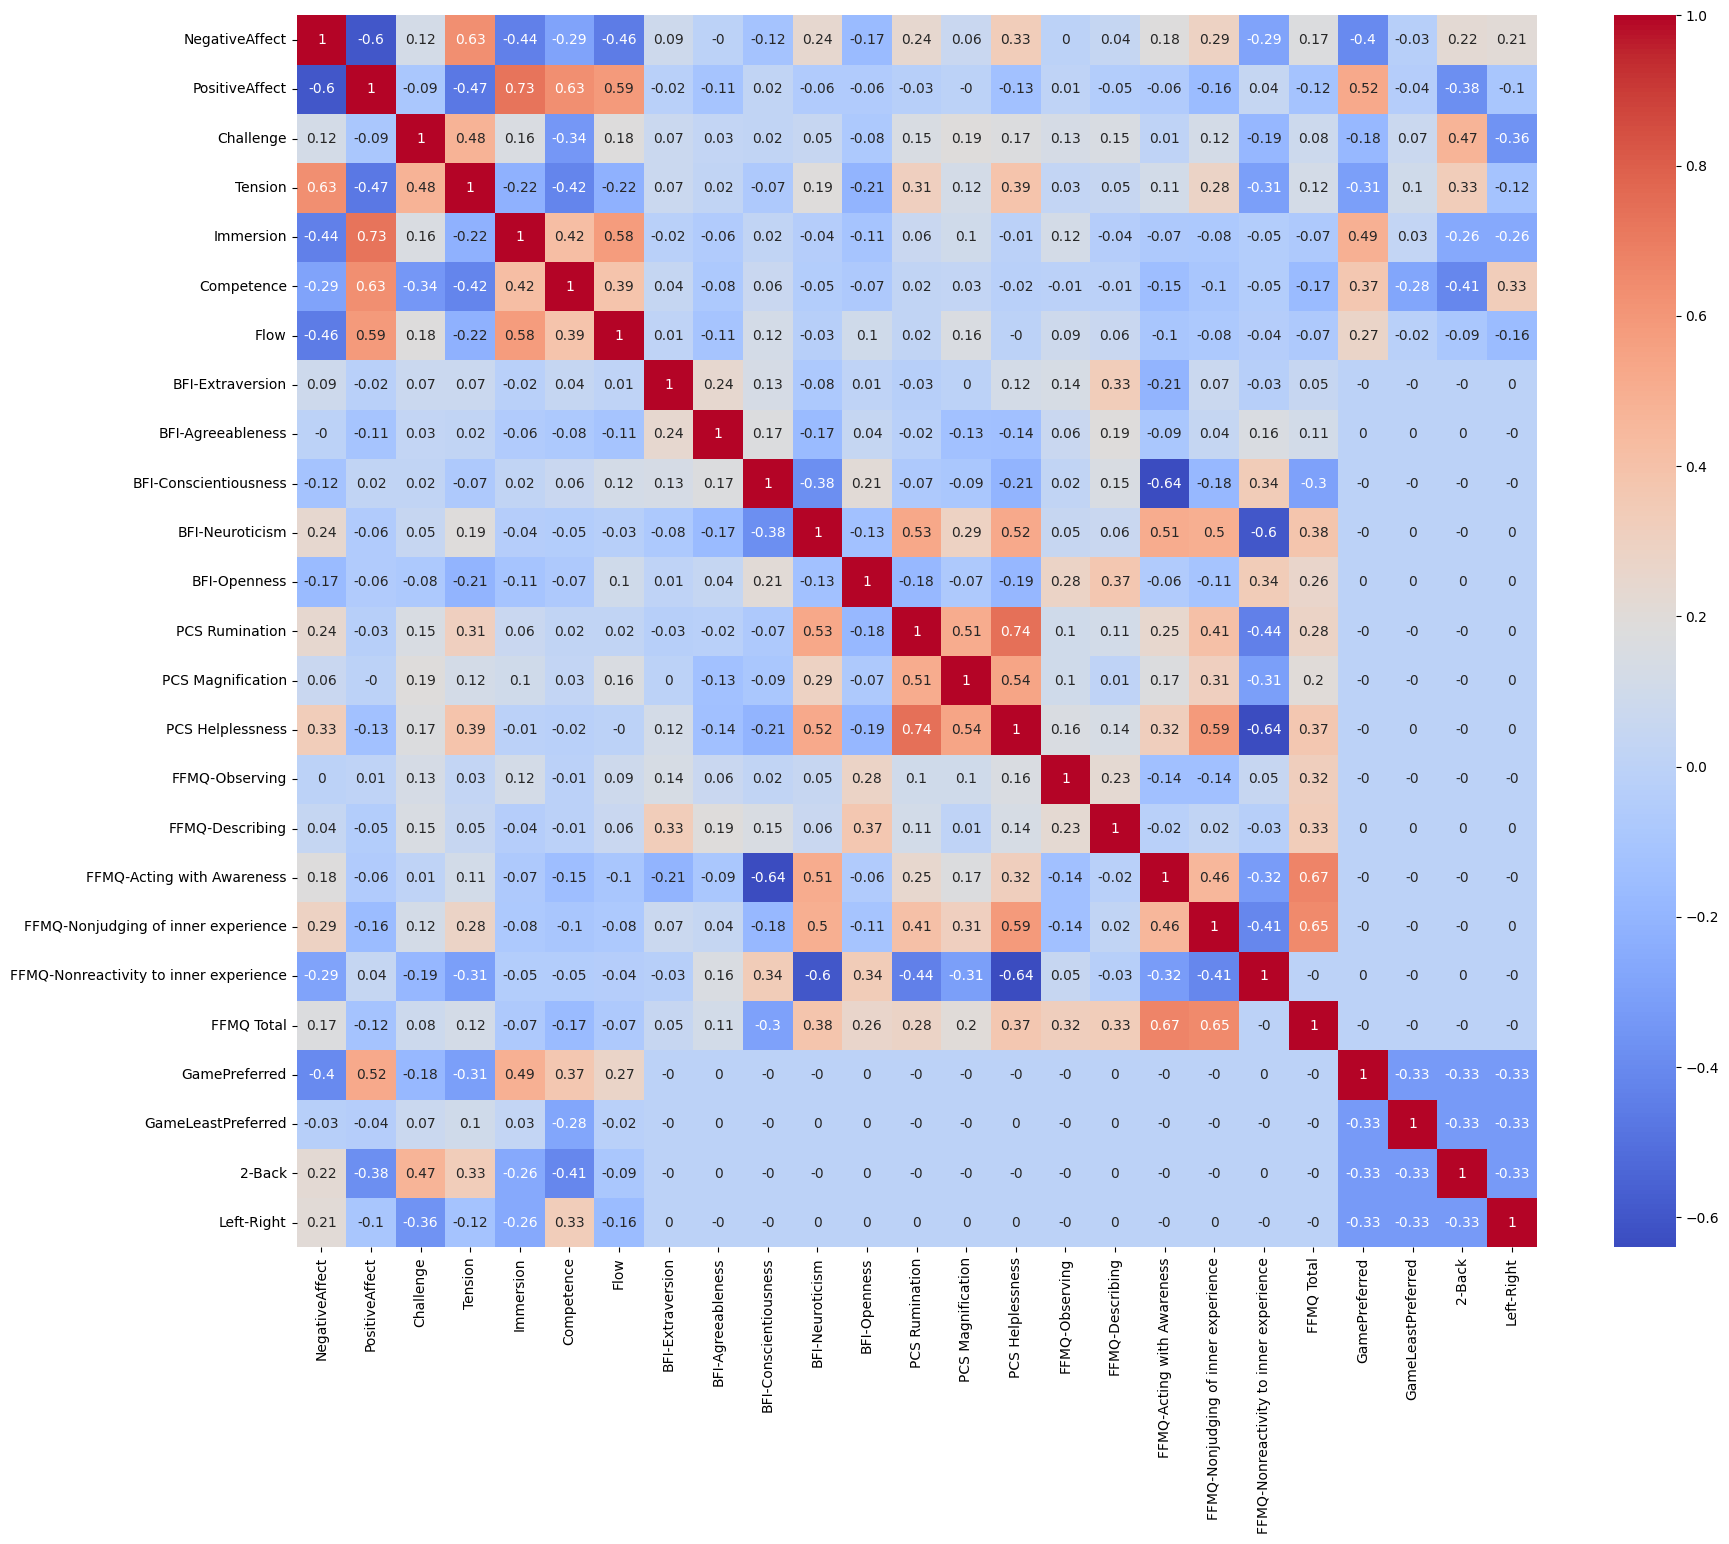

In [9]:
corr_matrix = full_df.corr().round(2)
plt.figure(figsize=(20,16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [10]:
labels

,Pain_Intensity_100to200,Unpleasantness-0to100
0,0.000,0.00
1,0.655,0.31
2,0.000,0.00
3,0.000,0.00
4,0.835,0.65
...,...,...
763,0.000,0.00
764,0.000,0.00
765,0.000,0.00
766,0.800,0.60


In [11]:
intensity = labels['Pain_Intensity_100to200']
unplea = labels['Unpleasantness-0to100']

In [12]:
unplea

,Unpleasantness-0to100
0,0.00
1,0.31
2,0.00
3,0.00
4,0.65
...,...
763,0.00
764,0.00
765,0.00
766,0.60


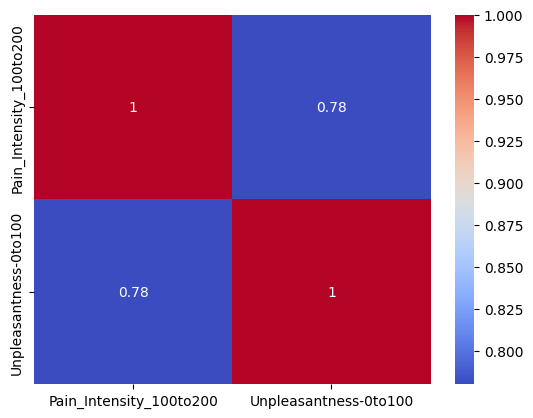

In [13]:
corr_matrix = labels.corr().round(2)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## Conditional independance Test

In [14]:
df = pd.read_excel('GameData.xlsx')

#Getting the right DF for inputs and labels
full_df = df.loc[:, ['NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow','BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total']]
labels = df.loc[:,['FinalPain_Intensity_0to200', 'Unpleasantness-0to100']]

one_hot = pd.get_dummies(df_data['ConditionType'])
full_df = pd.concat([df_data, one_hot], axis=1)
full_df.drop('ConditionType', axis=1, inplace=True)
renaming = {
    1: 'GP',
    2: 'GLP',
    3: '2B',
    4: 'LR'
}

full_df.rename(columns=renaming, inplace=True)
full_df
#Data Normalization/Processesing

scaler = MinMaxScaler()

for column in labels.columns:
  scaler.fit(labels[[column]])
  labels[column] = scaler.transform(labels[[column]])

for column in ['NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow','BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total']:
  scaler.fit(full_df[[column]])
  full_df[column] = scaler.transform(full_df[[column]])

full_df

,NegativeAffect,PositiveAffect,Challenge,Tension,Immersion,Competence,Flow,BFI-Extraversion,BFI-Agreeableness,BFI-Conscientiousness,...,FFMQ-Observing,FFMQ-Describing,FFMQ-Acting with Awareness,FFMQ-Nonjudging of inner experience,FFMQ-Nonreactivity to inner experience,FFMQ Total,GP,GLP,2B,LR
0,0.0625,0.70,0.1875,0.083333,0.578947,0.48,0.50,0.52,0.461538,0.645161,...,0.809524,0.4,0.200000,0.366667,0.666667,0.333333,True,False,False,False
1,0.0625,0.70,0.2500,0.083333,0.263158,0.36,0.50,0.52,0.461538,0.645161,...,0.809524,0.4,0.200000,0.366667,0.666667,0.333333,True,False,False,False
2,0.1250,0.55,0.1875,0.083333,0.368421,0.36,0.50,0.52,0.461538,0.645161,...,0.809524,0.4,0.200000,0.366667,0.666667,0.333333,True,False,False,False
3,0.2500,0.30,0.2500,0.166667,0.105263,0.04,0.15,0.52,0.461538,0.645161,...,0.809524,0.4,0.200000,0.366667,0.666667,0.333333,False,True,False,False
4,0.1875,0.30,0.1875,0.083333,0.052632,0.16,0.30,0.52,0.461538,0.645161,...,0.809524,0.4,0.200000,0.366667,0.666667,0.333333,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.6250,0.15,0.3750,0.250000,0.000000,0.32,0.10,0.80,0.884615,0.870968,...,0.761905,0.6,0.233333,1.000000,0.666667,0.740741,False,False,True,False
764,0.6875,0.10,0.6325,0.666667,0.000000,0.00,0.10,0.80,0.884615,0.870968,...,0.761905,0.6,0.233333,1.000000,0.666667,0.740741,False,False,True,False
765,0.5625,0.30,0.0000,0.166667,0.052632,0.72,0.30,0.80,0.884615,0.870968,...,0.761905,0.6,0.233333,1.000000,0.666667,0.740741,False,False,False,True
766,0.6875,0.15,0.2500,0.250000,0.000000,0.80,0.20,0.80,0.884615,0.870968,...,0.761905,0.6,0.233333,1.000000,0.666667,0.740741,False,False,False,True


In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_df,
                                                    unplea,
                                                    test_size=0.2,
                                                    random_state=42)


In [16]:
def conditional_independence_test(df, column1, column2, conditioned_columns):
    """
    Perform a conditional independence test using partial correlation.

    Parameters:
    - df: DataFrame
    - column1: str, name of the first column
    - column2: str, name of the second column
    - conditioned_columns: list of str, names of columns to condition on

    Returns:
    - p_value: float, p-value for the conditional independence test
    """

    # Combine all columns for the test
    all_columns = conditioned_columns + [column1, column2]

    # Compute partial correlation
    result = pg.partial_corr(data=df[all_columns], x=column1, y=column2, covar=conditioned_columns)

    # Extract p-value from the result
    p_value = result['p-val'].values[0]

    return p_value


In [17]:
conditional_independence_test(full_df, 'Competence', 'GLP', ['GP'])

np.float64(4.134397537290022e-07)

# Linear Regression

In [18]:
#LR
# Set up cross-validation

# Fit a linear regression model on the training data
model = LinearRegression()

# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Perform cross-validation on the training set
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
# Display cross-validation MAE scores
print("Cross-validation MAE scores:", -cv_scores)  # Negate the scores since cross_val_score returns negated values
print("Mean CV MAE:", -cv_scores.mean())

model.fit(X_train, y_train)

# Evaluate the model on the testing data
score = model.score(X_test, y_test)
print("R-squared score:", score)

y_pred = model.predict(X_test)

weights = model.coef_

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

Cross-validation MAE scores: [0.2105126  0.2168056  0.20925503 0.21570316 0.22342388]
Mean CV MAE: 0.2151400563749743
R-squared score: 0.06936840174908587
Mean Absolute Error: 0.21995027516318774
RMSE: 0.268105


In [19]:
weights

array([ 0.01407873,  0.08317249,  0.16510327, -0.00528379, -0.02106802,
       -0.01483207, -0.19768185,  0.21112568,  0.11762114,  0.06740589,
       -0.02069887,  0.00247987, -0.00249552, -0.1287304 ,  0.38493493,
       -0.03284553, -0.01115283, -0.03861143,  0.06292773, -0.04508837,
       -0.02240149, -0.05401452, -0.026821  ,  0.04625703,  0.0345785 ])

# Random Forest


In [20]:
# Create the Random Forest regression model with 100 trees
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set using MAE as the scoring metric
cv_scores = -cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Display cross-validation MAE scores
print("Cross-validation MAE scores:", cv_scores)
print("Mean CV MAE:", cv_scores.mean())
# Train the model on the training set
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model performance on the test set using the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Cross-validation MAE scores: [0.17653984 0.17689675 0.18553008 0.16846016 0.18330246]
Mean CV MAE: 0.17814585765693722
R2 score: 0.38686957059584726
RMSE: 0.217617
Mean Absolute Error: 0.16851688311688312


NegativeAffect: 0.06376637562486202
PositiveAffect: 0.0611332152665604
Challenge: 0.05599266399384139
Tension: 0.054893184464881076
Immersion: 0.04553981959091735
Competence: 0.0636763324095546
Flow: 0.07337279917495446
BFI-Extraversion: 0.0690683272450125
BFI-Agreeableness: 0.037480730797831
BFI-Conscientiousness: 0.029225848440728317
BFI-Neuroticism: 0.03333145952202341
BFI-Openness: 0.0419056306393013
PCS Rumination: 0.024884910323317452
PCS Magnification: 0.021638184218164463
PCS Helplessness: 0.07169270304684355
FFMQ-Observing: 0.03232907093701602
FFMQ-Describing: 0.018180777962123737
FFMQ-Acting with Awareness: 0.03302328725578712
FFMQ-Nonjudging of inner experience: 0.02695394858717599
FFMQ-Nonreactivity to inner experience: 0.021794469414943656
FFMQ Total: 0.0887469588279508
GP: 0.005458170459617672
GLP: 0.007728473069294186
2B: 0.010169171906160077
LR: 0.008013486821137427


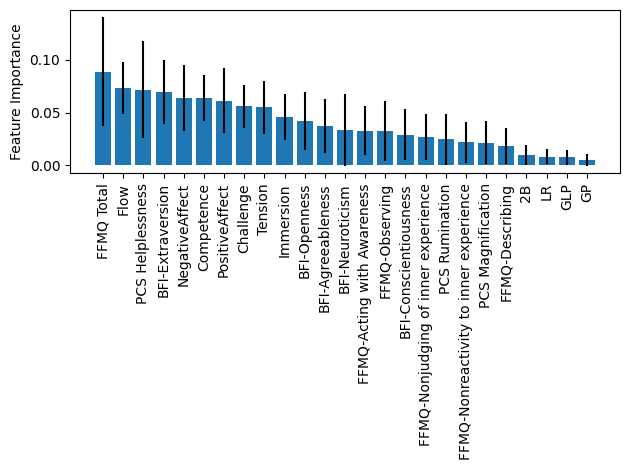

In [21]:
# Get the feature importances
importances = rf.feature_importances_

# Print the feature importances
for i, feature in enumerate(X_train.columns):
    print(f'{feature}: {importances[i]}')

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig, ax = plt.subplots()
ax.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align="center")
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(X_train.columns[indices], rotation=90)
ax.set_ylabel("Feature Importance")
plt.tight_layout()
plt.show()

BFI-Extraversion: 0.171 +/- 0.012
PCS Helplessness: 0.152 +/- 0.004
FFMQ Total: 0.140 +/- 0.007
Flow: 0.129 +/- 0.005
Tension: 0.093 +/- 0.004
NegativeAffect: 0.093 +/- 0.004
PositiveAffect: 0.078 +/- 0.003
Competence: 0.077 +/- 0.004
Challenge: 0.069 +/- 0.005
BFI-Openness: 0.063 +/- 0.003
Immersion: 0.060 +/- 0.002
BFI-Agreeableness: 0.045 +/- 0.002
FFMQ-Acting with Awareness: 0.043 +/- 0.002
FFMQ-Nonjudging of inner experience: 0.042 +/- 0.002
PCS Rumination: 0.036 +/- 0.002
BFI-Neuroticism: 0.035 +/- 0.002
FFMQ-Observing: 0.033 +/- 0.002
BFI-Conscientiousness: 0.033 +/- 0.002
PCS Magnification: 0.023 +/- 0.002
FFMQ-Nonreactivity to inner experience: 0.020 +/- 0.001
FFMQ-Describing: 0.017 +/- 0.001
2B: 0.013 +/- 0.001
GLP: 0.010 +/- 0.001
LR: 0.009 +/- 0.001
GP: 0.005 +/- 0.000


/tmp/ipython-input-924560796.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])


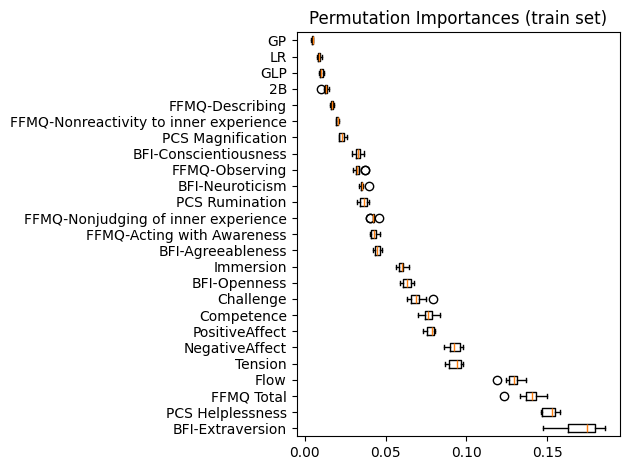

In [22]:
# Compute the permutation feature importances
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42)

# Sort the feature importances by descending order
sorted_idx = result.importances_mean.argsort()[::-1]

# Print the feature importance scores
for i in sorted_idx:
    print(f"{X_train.columns[i]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

# Plot the feature importance scores
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

# XGBoost

In [23]:
#XGB
# Define the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          max_depth = 20,
                          alpha = 10,
                          n_estimators = 200,
                          random_state=42)
# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set using MAE as the scoring metric
cv_scores = -cross_val_score(xg_reg, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Display cross-validation MAE scores
print("Cross-validation MAE scores:", cv_scores)
print("Mean CV MAE:", cv_scores.mean())

# Train the XGBoost model on the full training set
xg_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xg_reg.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

# Evaluate the model performance on the test set using the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Cross-validation MAE scores: [0.21240519 0.23535519 0.22714945 0.21796859 0.22942567]
Mean CV MAE: 0.224460817752656
RMSE: 0.253251
R2 score: 0.16963350363182916
Mean Absolute Error: 0.21580402276732705


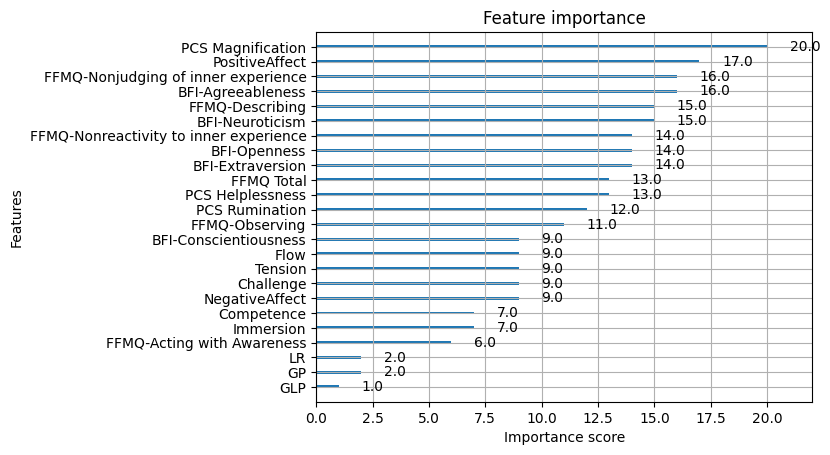

In [24]:
# Plot the feature importances
plot_importance(xg_reg)
plt.show()

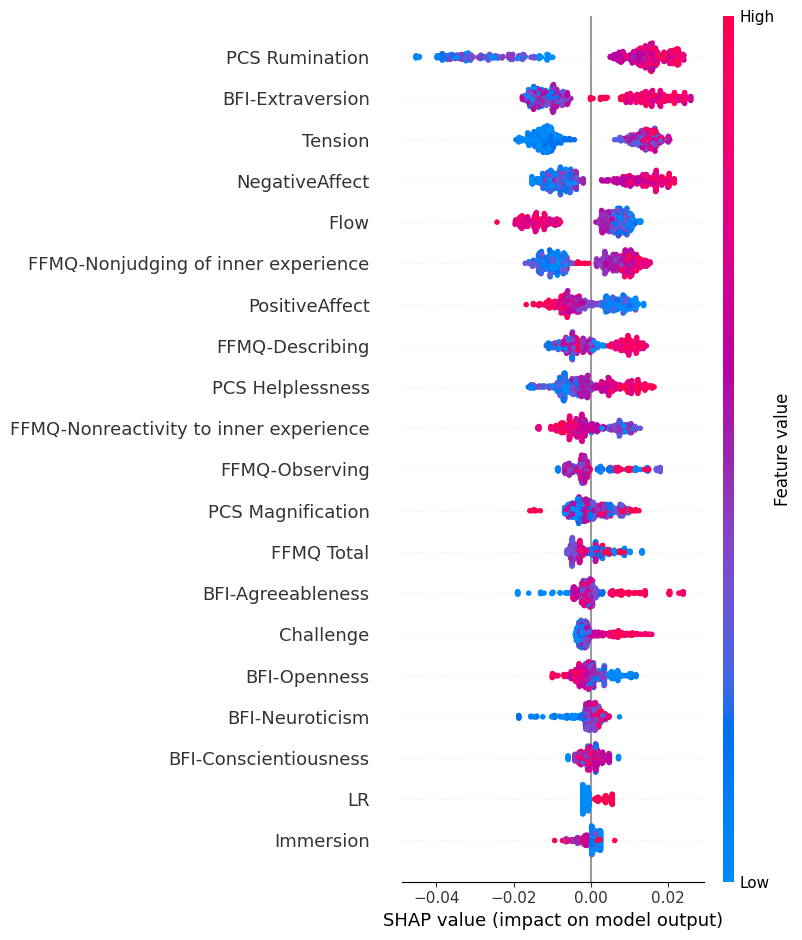

In [25]:
# Create a SHAP explainer object
explainer = shap.Explainer(xg_reg)

# Calculate the SHAP values for all the features
shap_values = explainer(X_train)

# Plot the SHAP values
shap.summary_plot(shap_values[:,:], X_train)

#DNN

In [26]:
import tensorflow as tf
from tensorflow import keras

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2562 - val_loss: 0.0784
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0694 - val_loss: 0.0649
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0573 - val_loss: 0.0626
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0561 - val_loss: 0.0610
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0566 - val_loss: 0.0608
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0520 - val_loss: 0.0594
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0501 - val_loss: 0.0587
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0525 - val_loss: 0.0594
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0520 - val_loss: 0.0576
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0509 - val_loss: 0.0578
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0485 - val_loss: 0.0566
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

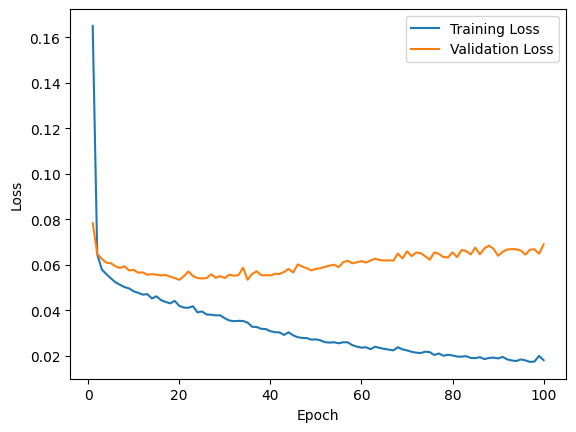

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
R2 score: -0.15474295616149902
Mean Absolute Error: 0.19909979403018951


In [27]:
#Random Forest of the No Missing Value Dataset

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_df,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)

# Define the DNN model architecture
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2)
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Define the training parameters
batch_size = 32
epochs = 100

# Train the model and collect the history
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs)

# Extract the training and validation losses from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt.plot(np.arange(1, epochs+1), train_loss, label='Training Loss')
plt.plot(np.arange(1, epochs+1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance on the test set using the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,432 (44.66 KB)

 Trainable params: 3,810 (14.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,622 (29.78 KB)

#Second run, cleaning the data further

In [29]:
test = df.loc[:,'FinalPain_Intensity_0to200']

In [30]:
scaler = MinMaxScaler()

scaled_column = scaler.fit_transform(test.values.reshape(-1, 1))

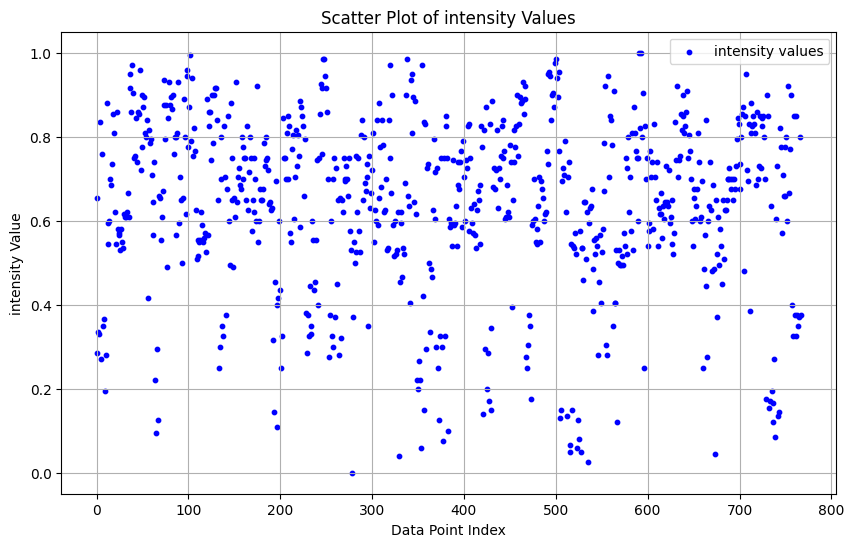

In [31]:
import matplotlib.pyplot as plt

# Assuming you have 'unplea' as a list or NumPy array
# If 'unplea' is a pandas Series, you can convert it to a list using 'unplea.values.tolist()'

plt.figure(figsize=(10, 6))  # Define the figure size

# Create a scatter plot of the 'unplea' values
plt.scatter(range(len(scaled_column)), scaled_column, s=10, c='b', marker='o', label='intensity values')

# Set labels and title
plt.xlabel('Data Point Index')
plt.ylabel('intensity Value')
plt.title('Scatter Plot of intensity Values')

plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-2679969657.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scaled_column, shade=True)  # Create a density plot


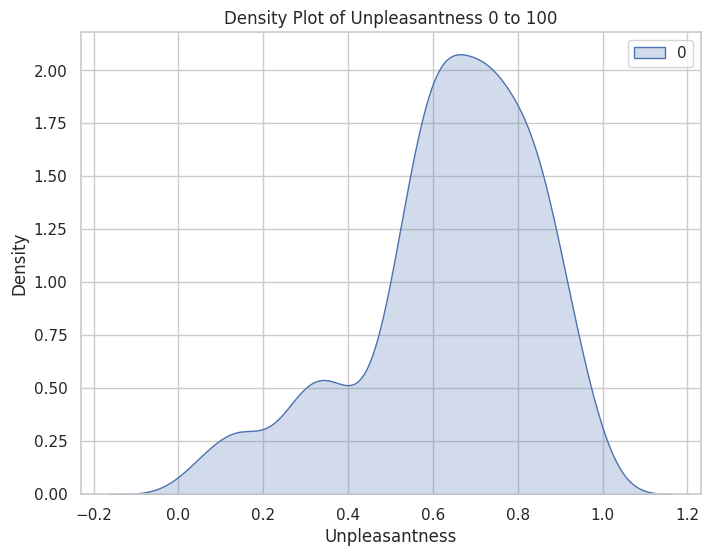

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame df with a "FinalPain" column
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))  # Set the figure size

sns.kdeplot(scaled_column, shade=True)  # Create a density plot
plt.title("Density Plot of Unpleasantness 0 to 100")
plt.xlabel("Unpleasantness")
plt.ylabel("Density")
plt.show()

In [102]:
df = pd.read_excel('GameData.xlsx')

#Getting the right DF for inputs and labels
#Removed PositiveAffect to fit in with Zoha/Roman
full_df = df.loc[:, ['NegativeAffect',
       'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow','BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total']]
labels = df.loc[:,['FinalPain_Intensity_0to200', 'Unpleasantness-0to100']]
for i in ['NegativeAffect',
       'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow']:
  full_df[i] = full_df[i].apply(lambda x: x**2)

#Data Normalization/Processesing

scaler = MinMaxScaler()

for column in labels.columns:
  scaler.fit(labels[[column]])
  labels[column] = scaler.transform(labels[[column]])

for column in ['NegativeAffect',
       'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow','BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total']:
  scaler.fit(full_df[[column]])
  full_df[column] = scaler.transform(full_df[[column]])

full_df


,NegativeAffect,Challenge,Tension,Immersion,Competence,Flow,BFI-Extraversion,BFI-Agreeableness,BFI-Conscientiousness,BFI-Neuroticism,BFI-Openness,PCS Rumination,PCS Magnification,PCS Helplessness,FFMQ-Observing,FFMQ-Describing,FFMQ-Acting with Awareness,FFMQ-Nonjudging of inner experience,FFMQ-Nonreactivity to inner experience,FFMQ Total
0,0.003906,0.035156,0.006944,0.335180,0.2304,0.2500,0.52,0.461538,0.645161,0.68,0.290323,0.5625,0.363636,0.363636,0.809524,0.4,0.200000,0.366667,0.666667,0.333333
1,0.003906,0.062500,0.006944,0.069252,0.1296,0.2500,0.52,0.461538,0.645161,0.68,0.290323,0.5625,0.363636,0.363636,0.809524,0.4,0.200000,0.366667,0.666667,0.333333
2,0.015625,0.035156,0.006944,0.135734,0.1296,0.2500,0.52,0.461538,0.645161,0.68,0.290323,0.5625,0.363636,0.363636,0.809524,0.4,0.200000,0.366667,0.666667,0.333333
3,0.062500,0.062500,0.027778,0.011080,0.0016,0.0225,0.52,0.461538,0.645161,0.68,0.290323,0.5625,0.363636,0.363636,0.809524,0.4,0.200000,0.366667,0.666667,0.333333
4,0.035156,0.035156,0.006944,0.002770,0.0256,0.0900,0.52,0.461538,0.645161,0.68,0.290323,0.5625,0.363636,0.363636,0.809524,0.4,0.200000,0.366667,0.666667,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.390625,0.140625,0.062500,0.000000,0.1024,0.0100,0.80,0.884615,0.870968,0.52,0.387097,0.5625,0.363636,0.545455,0.761905,0.6,0.233333,1.000000,0.666667,0.740741
764,0.472656,0.400056,0.444444,0.000000,0.0000,0.0100,0.80,0.884615,0.870968,0.52,0.387097,0.5625,0.363636,0.545455,0.761905,0.6,0.233333,1.000000,0.666667,0.740741
765,0.316406,0.000000,0.027778,0.002770,0.5184,0.0900,0.80,0.884615,0.870968,0.52,0.387097,0.5625,0.363636,0.545455,0.761905,0.6,0.233333,1.000000,0.666667,0.740741
766,0.472656,0.062500,0.062500,0.000000,0.6400,0.0400,0.80,0.884615,0.870968,0.52,0.387097,0.5625,0.363636,0.545455,0.761905,0.6,0.233333,1.000000,0.666667,0.740741


In [103]:
intensity = labels['FinalPain_Intensity_0to200']
unplea = labels['Unpleasantness-0to100']

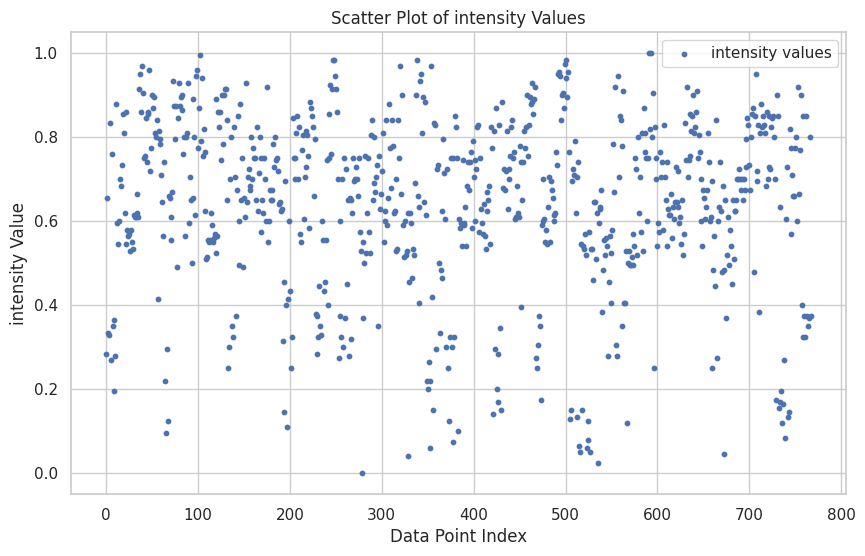

In [35]:
import matplotlib.pyplot as plt

# Assuming you have 'unplea' as a list or NumPy array
# If 'unplea' is a pandas Series, you can convert it to a list using 'unplea.values.tolist()'

plt.figure(figsize=(10, 6))  # Define the figure size

# Create a scatter plot of the 'unplea' values
plt.scatter(range(len(unplea)), intensity, s=10, c='b', marker='o', label='intensity values')

# Set labels and title
plt.xlabel('Data Point Index')
plt.ylabel('intensity Value')
plt.title('Scatter Plot of intensity Values')

plt.legend()
plt.grid(True)
plt.show()

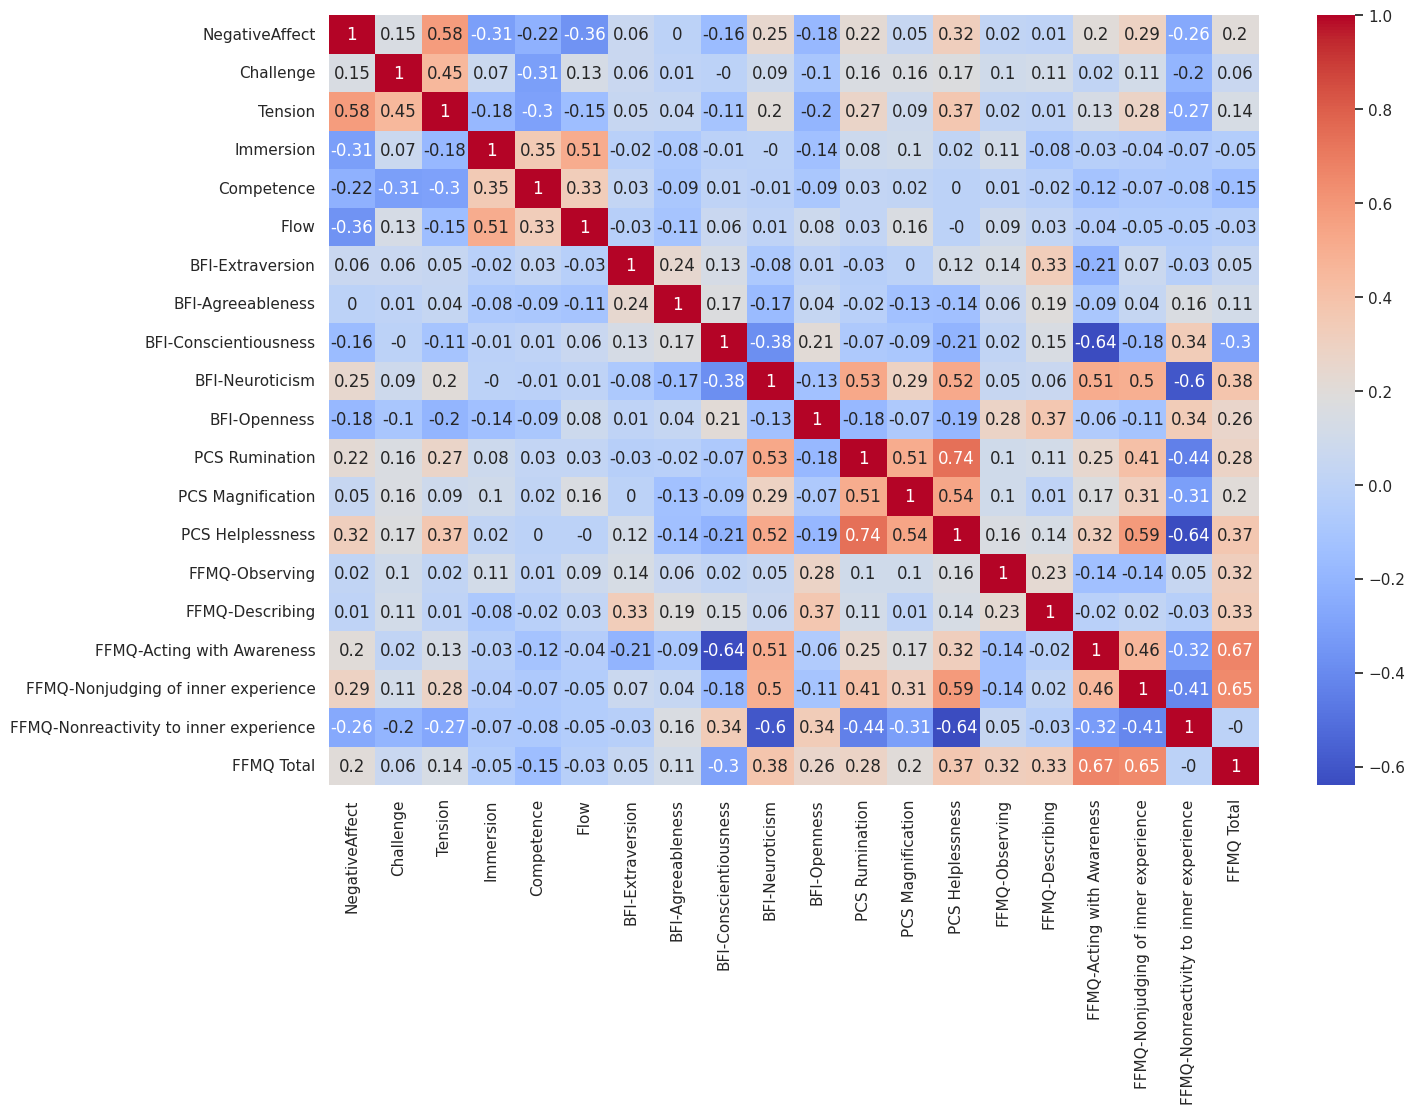

In [36]:
corr_matrix = full_df.corr().round(2)
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [104]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_df,
                                                    unplea,
                                                    test_size=0.2,
                                                    random_state=42)



# Models without Tasks


In [105]:
#LR
# Set up cross-validation

# Fit a linear regression model on the training data
model = LinearRegression()

# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Perform cross-validation on the training set
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
# Display cross-validation MAE scores
print("Cross-validation MAE scores:", -cv_scores)  # Negate the scores since cross_val_score returns negated values
print("Mean CV MAE:", -cv_scores.mean())

model.fit(X_train, y_train)

# Evaluate the model on the testing data
score = model.score(X_test, y_test)
print("R-squared score:", score)

y_pred = model.predict(X_test)

weights = model.coef_

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

Cross-validation MAE scores: [0.2043701  0.21801051 0.21324866 0.21764824 0.22961433]
Mean CV MAE: 0.21657836797039245
R-squared score: 0.07309518690705996
Mean Absolute Error: 0.21830822803737848
RMSE: 0.267568


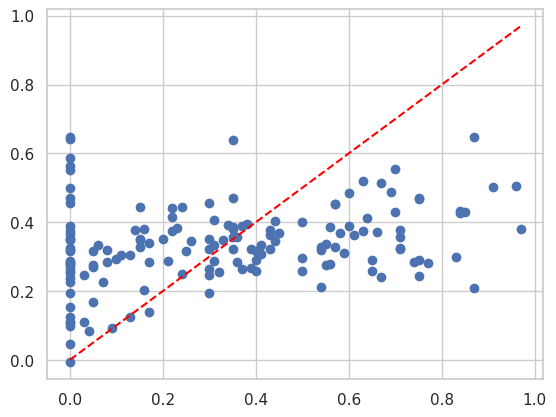

In [39]:
plt.scatter(y_test,y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='y=x')

In [40]:
print(weights)

[ 0.07689187  0.23603259 -0.00035465 -0.11645936  0.08002808 -0.15782748
  0.20014314  0.11463249  0.06192428 -0.03808119 -0.0074321   0.00682
 -0.11259825  0.33645883 -0.01610743 -0.0262053  -0.01520166  0.05494953
 -0.04157661 -0.00993959]


In [106]:
# Create the Random Forest regression model with 100 trees
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set using MAE as the scoring metric
cv_scores = -cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Display cross-validation MAE scores
print("Cross-validation MAE scores:", cv_scores)
print("Mean CV MAE:", cv_scores.mean())
# Train the model on the training set
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model performance on the test set using the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Cross-validation MAE scores: [0.17467886 0.1769878  0.18281057 0.16642683 0.18846066]
Mean CV MAE: 0.17787294415567106
R2 score: 0.3781775688170357
RMSE: 0.219154
Mean Absolute Error: 0.16821103896103895


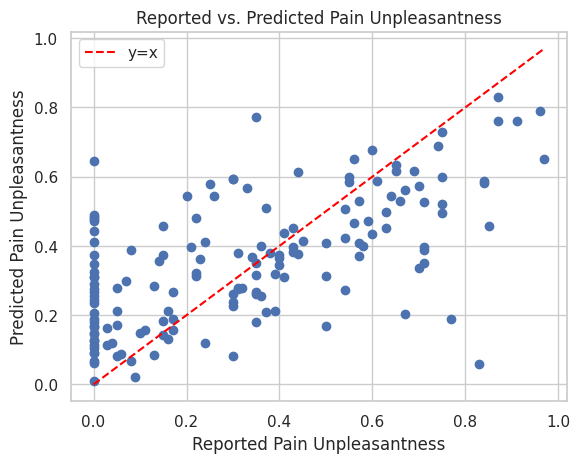

In [112]:
plt.scatter(y_test,y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='y=x')
# Adding labels and title
plt.xlabel('Reported Pain Unpleasantness')
plt.ylabel('Predicted Pain Unpleasantness')
plt.title('Reported vs. Predicted Pain Unpleasantness')
plt.savefig("Rf_predictions.svg", format="svg", dpi=300)
plt.legend()


NegativeAffect: 0.07920208195813011
Challenge: 0.06719968721607075
Tension: 0.06187263837603846
Immersion: 0.06208619351544077
Competence: 0.0790025183587551
Flow: 0.08748263328080055
BFI-Extraversion: 0.06993498424833985
BFI-Agreeableness: 0.03929859479897692
BFI-Conscientiousness: 0.029087804737077328
BFI-Neuroticism: 0.03633047682596685
BFI-Openness: 0.04630571353871746
PCS Rumination: 0.026035010812090576
PCS Magnification: 0.022831178656418236
PCS Helplessness: 0.07081991596588047
FFMQ-Observing: 0.032820611354331355
FFMQ-Describing: 0.01872017386522602
FFMQ-Acting with Awareness: 0.035147500866265356
FFMQ-Nonjudging of inner experience: 0.027882397685768254
FFMQ-Nonreactivity to inner experience: 0.020272804497461123
FFMQ Total: 0.08766707944224435


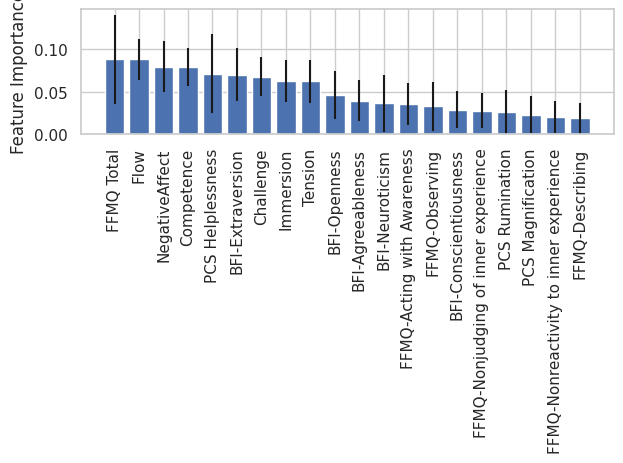

In [43]:
# Get the feature importances
importances = rf.feature_importances_

# Print the feature importances
for i, feature in enumerate(X_train.columns):
    print(f'{feature}: {importances[i]}')

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig, ax = plt.subplots()
ax.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align="center")
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(X_train.columns[indices], rotation=90)
ax.set_ylabel("Feature Importance")
plt.tight_layout()
plt.show()

BFI-Extraversion: 0.166 +/- 0.012
Flow: 0.159 +/- 0.006
PCS Helplessness: 0.145 +/- 0.004
FFMQ Total: 0.135 +/- 0.007
NegativeAffect: 0.119 +/- 0.005
Tension: 0.107 +/- 0.004
Competence: 0.099 +/- 0.004
Immersion: 0.092 +/- 0.003
Challenge: 0.089 +/- 0.006
BFI-Openness: 0.071 +/- 0.004
BFI-Agreeableness: 0.047 +/- 0.002
FFMQ-Acting with Awareness: 0.045 +/- 0.002
FFMQ-Nonjudging of inner experience: 0.043 +/- 0.001
BFI-Neuroticism: 0.041 +/- 0.002
PCS Rumination: 0.040 +/- 0.002
FFMQ-Observing: 0.035 +/- 0.002
BFI-Conscientiousness: 0.034 +/- 0.002
PCS Magnification: 0.024 +/- 0.002
FFMQ-Nonreactivity to inner experience: 0.019 +/- 0.001
FFMQ-Describing: 0.016 +/- 0.001


/tmp/ipython-input-2836701876.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])


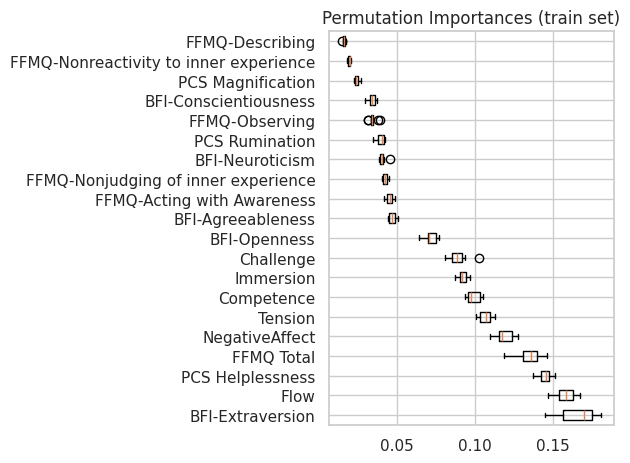

In [44]:
from sklearn.inspection import permutation_importance

# Compute the permutation feature importances
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42)

# Sort the feature importances by descending order
sorted_idx = result.importances_mean.argsort()[::-1]

# Print the feature importance scores
for i in sorted_idx:
    print(f"{X_train.columns[i]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

# Plot the feature importance scores
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

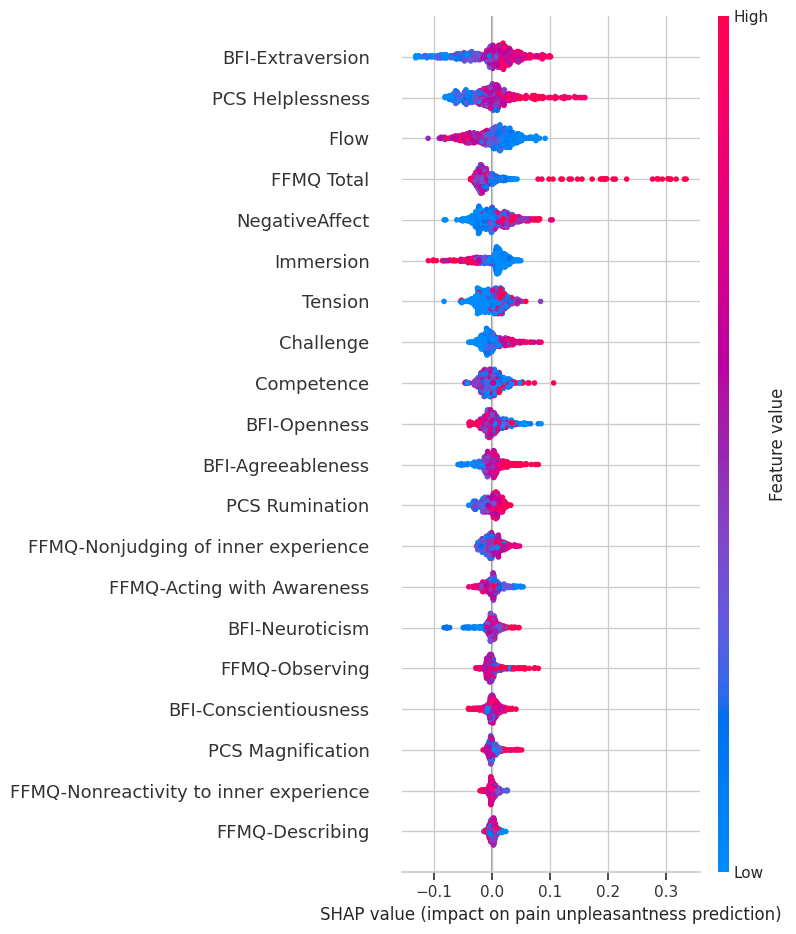

In [109]:
# Create a SHAP explainer object
explainer = shap.Explainer(rf)

# Calculate the SHAP values for all the features
shap_values = explainer(X_train)

# Plot the SHAP values
shap.summary_plot(shap_values[:,:], X_train, show=False)
plt.xlabel('SHAP value (impact on pain unpleasantness prediction)', fontsize=12)
# Save the figure as SVG
plt.savefig("shap_summary.svg", format="svg", dpi=300)
plt.show()

In [46]:
labels.columns

Index(['FinalPain_Intensity_0to200', 'Unpleasantness-0to100'], dtype='object')

In [47]:
#XGB
# Define the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          max_depth = 20,
                          alpha = 10,
                          n_estimators = 200,
                          random_state=42)
# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set using MAE as the scoring metric
cv_scores = -cross_val_score(xg_reg, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Display cross-validation MAE scores
print("Cross-validation MAE scores:", cv_scores)
print("Mean CV MAE:", cv_scores.mean())

# Train the XGBoost model on the full training set
xg_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xg_reg.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

# Evaluate the model performance on the test set using the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Cross-validation MAE scores: [0.21028258 0.23358778 0.22893353 0.21585745 0.22892159]
Mean CV MAE: 0.22351658730571722
RMSE: 0.251259
R2 score: 0.18264445346605263
Mean Absolute Error: 0.2144463355897309


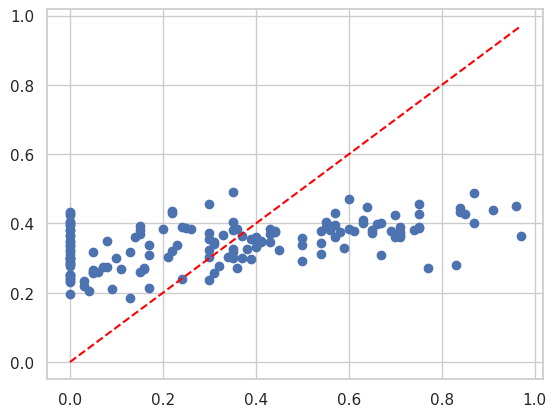

In [48]:
plt.scatter(y_test,y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='y=x')

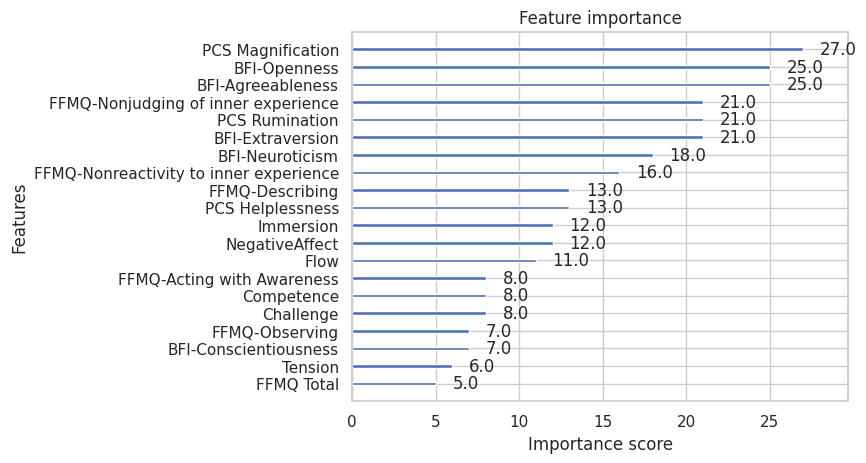

In [49]:
# Plot the feature importances
plot_importance(xg_reg)
plt.show()

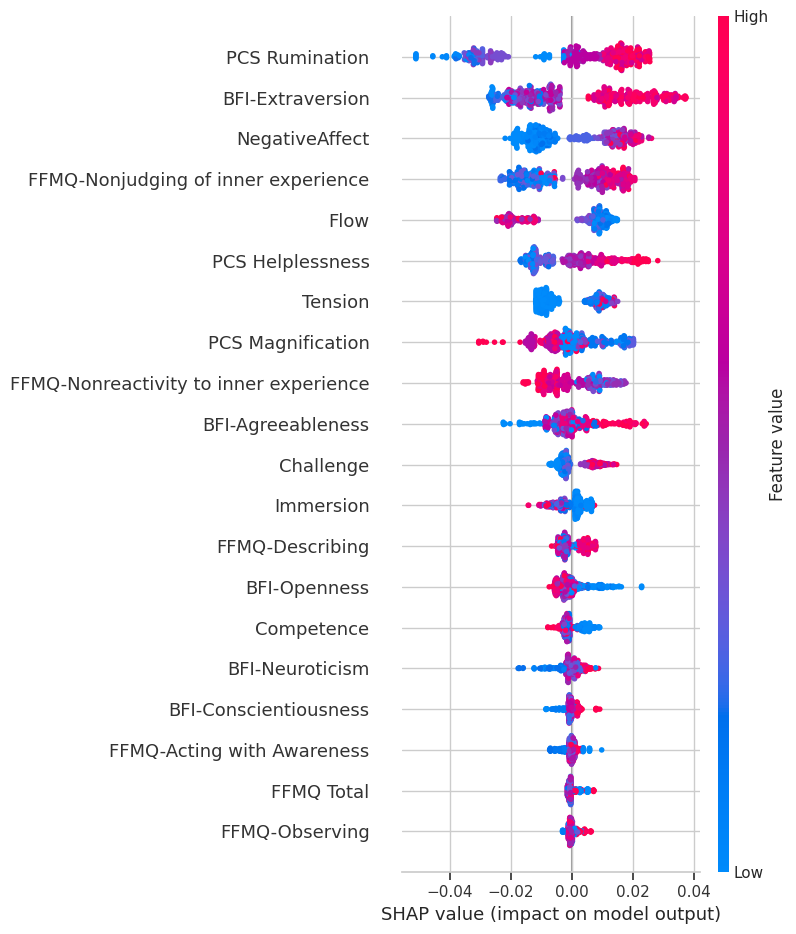

In [50]:
# Create a SHAP explainer object
explainer = shap.Explainer(xg_reg)

# Calculate the SHAP values for all the features
shap_values = explainer(X_train)

# Plot the SHAP values
shap.summary_plot(shap_values[:,:], X_train)

## Seperate per task

In [51]:
df = pd.read_excel('GameData.xlsx')

#Getting the right DF for inputs and labels
full_df = df.loc[:, ['ConditionType','NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow','BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total','Pain_Intensity_100to200', 'Unpleasantness-0to100']]

#Data Normalization/Processesing

scaler = MinMaxScaler()

for column in ['NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow','BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total','Pain_Intensity_100to200', 'Unpleasantness-0to100']:
  scaler.fit(full_df[[column]])
  full_df[column] = scaler.transform(full_df[[column]])

# 1: 'GP',  2: 'GLP', 3: '2B', 4: 'LR'

grouped_df = full_df.groupby('ConditionType')

tasks = []
dfs = []
labels=[]
for task_name, df in grouped_df:
  tasks.append(task_name)
  dfs.append(df)

In [52]:
for i in range(4):
  label = dfs[i].loc[:,['Pain_Intensity_100to200','Unpleasantness-0to100']]
  labels.append(label)
  dfs[i] = dfs[i].drop(columns=['ConditionType','Pain_Intensity_100to200', 'Unpleasantness-0to100'])

In [53]:
flows =[]
unpleas=[]
for i in range(4):
  flow = dfs[i].loc[:,['Flow']]
  flows.append(flow)
  unplea = labels[i]['Unpleasantness-0to100']
  unpleas.append(unplea)


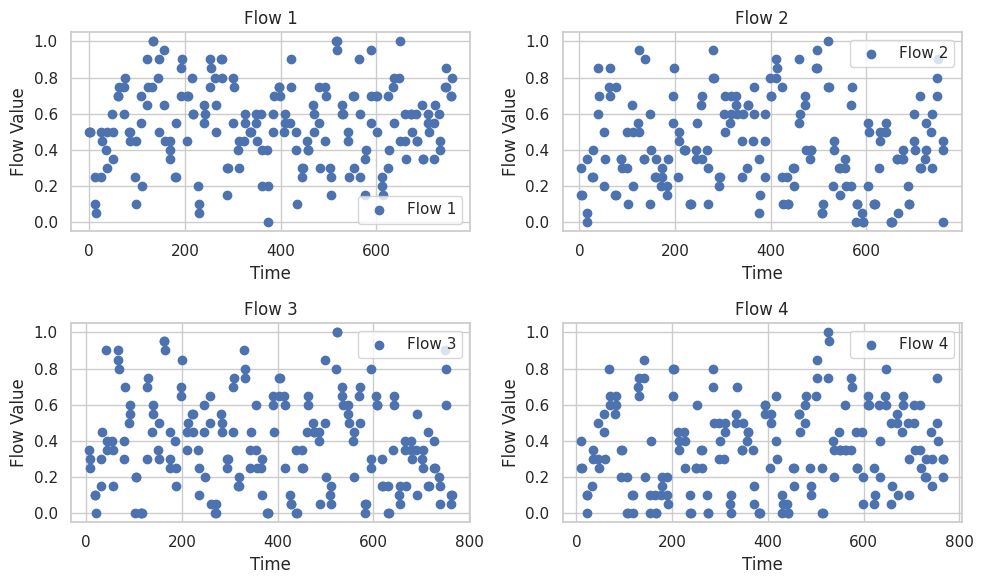

In [54]:
import matplotlib.pyplot as plt

# Assuming dfs is a list of DataFrames containing 'Flow' column
flows = [df.loc[:, ['Flow']] for df in dfs]

# Plotting the flows in a single figure
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot each flow in a subplot
for i, flow in enumerate(flows, start=1):
    plt.subplot(2, 2, i)  # Adjust the subplot grid based on your needs
    plt.scatter(flow.index, flow['Flow'], label=f'Flow {i}', marker='o')
    plt.title(f'Flow {i}')
    plt.xlabel('Time')
    plt.ylabel('Flow Value')
    plt.legend()

plt.tight_layout()  # Adjust the layout for better spacing
plt.show()



In [55]:
mean= [flows[0].mean(),flows[1].mean(),flows[2].mean(),flows[3].mean()]
mean

[Flow    0.542448
 dtype: float64,
 Flow    0.416146
 dtype: float64,
 Flow    0.386979
 dtype: float64,
 Flow    0.357552
 dtype: float64]

In [56]:
labels[0]

,Pain_Intensity_100to200,Unpleasantness-0to100
0,0.000,0.00
1,0.655,0.31
2,0.000,0.00
12,0.595,0.19
13,0.545,0.80
...,...,...
745,0.775,0.60
746,0.570,0.08
756,0.900,0.69
757,0.000,0.00


In [57]:
# CHANGE HERE THE INDEX TO CHANGE THE TASK
X_train, X_test, y_train, y_test = train_test_split(dfs[3],
                                                    unpleas[3],
                                                    test_size=0.2,
                                                    random_state=42)



In [58]:
#LR
# Set up cross-validation

# Fit a linear regression model on the training data
model = LinearRegression()

# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Perform cross-validation on the training set
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
# Display cross-validation MAE scores
print("Cross-validation MAE scores:", -cv_scores)  # Negate the scores since cross_val_score returns negated values
print("Mean CV MAE:", -cv_scores.mean())

model.fit(X_train, y_train)

# Evaluate the model on the testing data
score = model.score(X_test, y_test)
print("R-squared score:", score)

y_pred = model.predict(X_test)

weights = model.coef_

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

Cross-validation MAE scores: [0.26799454 0.20676781 0.27453898 0.22784865 0.30929106]
Mean CV MAE: 0.2572882095036571
R-squared score: 0.0948005370213808
Mean Absolute Error: 0.19064415928778752
RMSE: 0.242492


In [59]:
y_test

,Unpleasantness-0to100
189,0.26
550,0.07
310,0.20
575,0.00
455,0.39
717,0.61
69,0.27
81,0.55
70,0.08
45,0.20


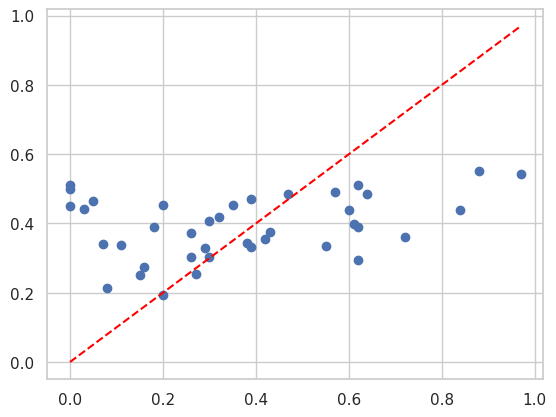

In [60]:
plt.scatter(y_test,y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='y=x')

In [61]:
# Create the Random Forest regression model with 100 trees
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set using MAE as the scoring metric
cv_scores = -cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Display cross-validation MAE scores
print("Cross-validation MAE scores:", cv_scores)
print("Mean CV MAE:", cv_scores.mean())
# Train the model on the training set
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model performance on the test set using the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Cross-validation MAE scores: [0.23181935 0.20335484 0.26073548 0.24452    0.27021   ]
Mean CV MAE: 0.24212793548387096
R2 score: 0.4401370269985788
RMSE: 0.190707
Mean Absolute Error: 0.14477948717948724


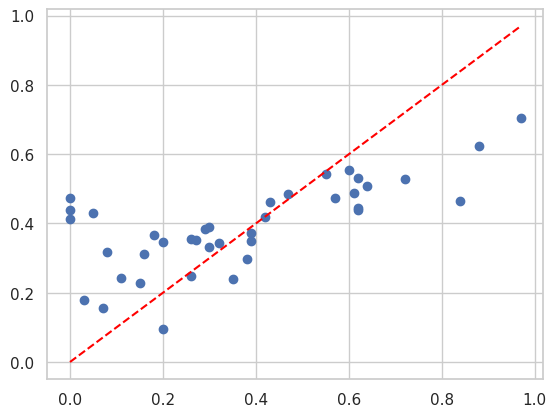

In [62]:
plt.scatter(y_test,y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='y=x')


NegativeAffect: 0.07413323152753218
PositiveAffect: 0.07756821311847517
Challenge: 0.04998913711162359
Tension: 0.05210752876528666
Immersion: 0.02975902412760961
Competence: 0.07985151007440656
Flow: 0.0540245795541965
BFI-Extraversion: 0.1090722100097912
BFI-Agreeableness: 0.03277258299126921
BFI-Conscientiousness: 0.03386410276833925
BFI-Neuroticism: 0.037966439466934836
BFI-Openness: 0.028085326115633528
PCS Rumination: 0.02691265096565048
PCS Magnification: 0.018275261535986694
PCS Helplessness: 0.08762742774586828
FFMQ-Observing: 0.033396449218842994
FFMQ-Describing: 0.037666895118505905
FFMQ-Acting with Awareness: 0.029233080727349994
FFMQ-Nonjudging of inner experience: 0.019894505121302333
FFMQ-Nonreactivity to inner experience: 0.021531123388247277
FFMQ Total: 0.06626872054714796


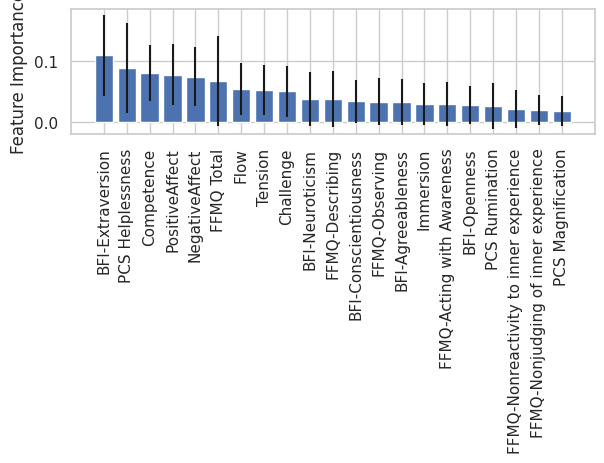

In [63]:
# Get the feature importances
importances = rf.feature_importances_

# Print the feature importances
for i, feature in enumerate(X_train.columns):
    print(f'{feature}: {importances[i]}')

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig, ax = plt.subplots()
ax.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align="center")
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(X_train.columns[indices], rotation=90)
ax.set_ylabel("Feature Importance")
plt.tight_layout()
plt.show()

BFI-Extraversion: 0.244 +/- 0.038
PCS Helplessness: 0.202 +/- 0.026
PositiveAffect: 0.116 +/- 0.012
Competence: 0.101 +/- 0.006
NegativeAffect: 0.081 +/- 0.006
FFMQ Total: 0.077 +/- 0.007
Challenge: 0.066 +/- 0.005
Flow: 0.065 +/- 0.005
Tension: 0.058 +/- 0.005
BFI-Neuroticism: 0.040 +/- 0.003
FFMQ-Describing: 0.039 +/- 0.005
BFI-Agreeableness: 0.038 +/- 0.004
FFMQ-Observing: 0.038 +/- 0.004
BFI-Conscientiousness: 0.034 +/- 0.004
PCS Rumination: 0.034 +/- 0.004
FFMQ-Acting with Awareness: 0.030 +/- 0.003
Immersion: 0.030 +/- 0.003
BFI-Openness: 0.027 +/- 0.002
FFMQ-Nonreactivity to inner experience: 0.022 +/- 0.002
PCS Magnification: 0.020 +/- 0.003
FFMQ-Nonjudging of inner experience: 0.016 +/- 0.001


/tmp/ipython-input-2836701876.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])


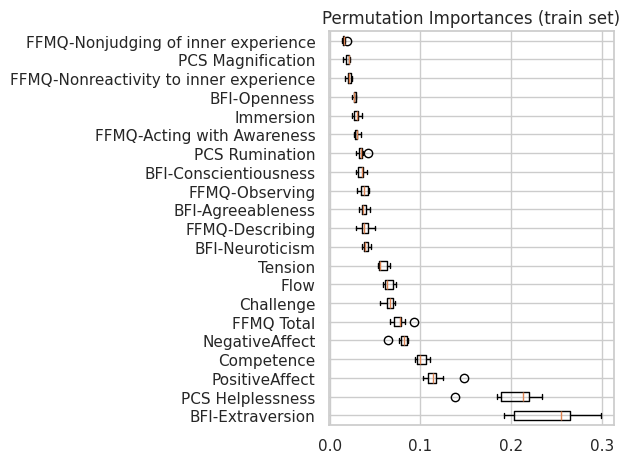

In [64]:
from sklearn.inspection import permutation_importance

# Compute the permutation feature importances
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42)

# Sort the feature importances by descending order
sorted_idx = result.importances_mean.argsort()[::-1]

# Print the feature importance scores
for i in sorted_idx:
    print(f"{X_train.columns[i]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

# Plot the feature importance scores
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

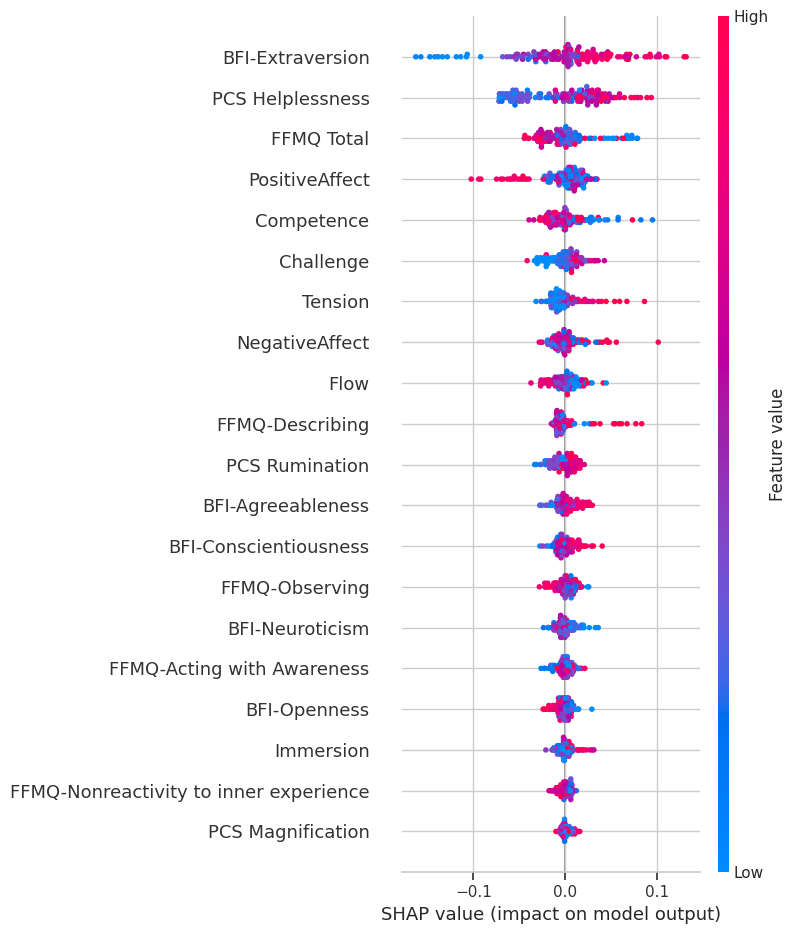

In [65]:
# Create a SHAP explainer object
explainer = shap.Explainer(rf)

# Calculate the SHAP values for all the features
shap_values = explainer(X_train)

# Plot the SHAP values
shap.summary_plot(shap_values[:,:], X_train)

In [66]:
#XGB
# Define the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          max_depth = 20,
                          alpha = 10,
                          n_estimators = 200,
                          random_state=42)
# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set using MAE as the scoring metric
cv_scores = -cross_val_score(xg_reg, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Display cross-validation MAE scores
print("Cross-validation MAE scores:", cv_scores)
print("Mean CV MAE:", cv_scores.mean())

# Train the XGBoost model on the full training set
xg_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xg_reg.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

# Evaluate the model performance on the test set using the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Cross-validation MAE scores: [0.25358276 0.22773929 0.23836594 0.23403252 0.25023849]
Mean CV MAE: 0.24079179943658974
RMSE: 0.255105
R2 score: -0.001812098829514941
Mean Absolute Error: 0.21211664071449862


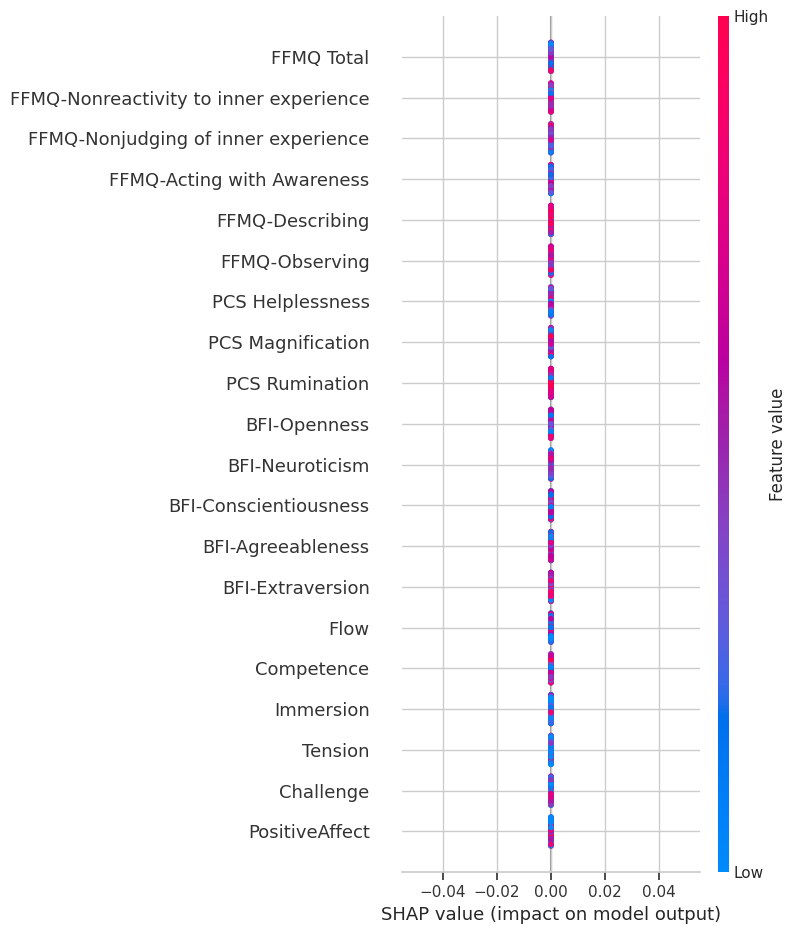

In [67]:
# Create a SHAP explainer object
explainer = shap.Explainer(xg_reg)

# Calculate the SHAP values for all the features
shap_values = explainer(X_train)

# Plot the SHAP values
shap.summary_plot(shap_values[:,:], X_train)

## Redo the graph per task

In [68]:
df = pd.read_excel('GameData.xlsx')

#Getting the right DF for inputs and labels
full_df = df.loc[:, ['NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow','BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total']]
labels = df.loc[:,['FinalPain_Intensity_0to200', 'Unpleasantness-0to100']]
#Data Normalization/Processesing

scaler = MinMaxScaler()

for column in labels.columns:
  scaler.fit(labels[[column]])
  labels[column] = scaler.transform(labels[[column]])

for column in ['NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow','BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total']:
  scaler.fit(full_df[[column]])
  full_df[column] = scaler.transform(full_df[[column]])

intensity = labels['FinalPain_Intensity_0to200']
unplea = labels['Unpleasantness-0to100']


In [69]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_df,
                                                    unplea,
                                                    test_size=0.2,
                                                    random_state=42)



In [70]:
# Create the Random Forest regression model with 100 trees
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set using MAE as the scoring metric
cv_scores = -cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Display cross-validation MAE scores
print("Cross-validation MAE scores:", cv_scores)
print("Mean CV MAE:", cv_scores.mean())
# Train the model on the training set
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model performance on the test set using the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Cross-validation MAE scores: [0.17435285 0.17588049 0.18597967 0.17106911 0.18560902]
Mean CV MAE: 0.17857822604291618
R2 score: 0.40584009333410775
RMSE: 0.214224
Mean Absolute Error: 0.1662792207792208


In [71]:
df = pd.read_excel('GameData.xlsx')

#Getting the right DF for inputs and labels
full_df_Cond = df.loc[:, ['NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow','BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total', 'ConditionType']]

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(full_df_Cond,
                                                    unplea,
                                                    test_size=0.2,
                                                    random_state=42)

# Define your conditions
condition_type = 4  # Replace with the condition you want to apply

# Apply conditions to create a subset of the test set
subset_indices = (X_test2['ConditionType'] == condition_type)
X_test_subset = X_test[subset_indices]


In [72]:
# Make predictions on the subset using the trained Random Forest model
y_pred_subset = rf.predict(X_test_subset)

# Now you have predictions for the subset of the test set that meets your conditions

# Evaluate the model performance on the subset
mae_subset = mean_absolute_error(y_test[subset_indices], y_pred_subset)
print(f'Mean Absolute Error on the subset (Condition {condition_type}):', mae_subset)

Mean Absolute Error on the subset (Condition 4): 0.1757400000000001


In [73]:
y_pred_subset.mean()

np.float64(0.40247999999999995)

## Without Participant Data and GEQ squared



In [74]:
df = pd.read_excel('GameData.xlsx')

#Getting the right DF for inputs and labels
full_df = df.loc[:, ['NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow']]
labels = df.loc[:,['FinalPain_Intensity_0to200', 'Unpleasantness-0to100']]

for i in ['NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow']:
  full_df[i] = full_df[i].apply(lambda x: x**2)

#Data Normalization/Processesing

scaler = MinMaxScaler()

for column in labels.columns:
  scaler.fit(labels[[column]])
  labels[column] = scaler.transform(labels[[column]])

for column in ['NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow']:
  scaler.fit(full_df[[column]])
  full_df[column] = scaler.transform(full_df[[column]])

full_df
intensity = labels['FinalPain_Intensity_0to200']
unplea = labels['Unpleasantness-0to100']

In [75]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_df,
                                                    unplea,
                                                    test_size=0.2,
                                                    random_state=42)



In [76]:
#LR
# Set up cross-validation

# Fit a linear regression model on the training data
model = LinearRegression()

# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Perform cross-validation on the training set
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
# Display cross-validation MAE scores
print("Cross-validation MAE scores:", -cv_scores)  # Negate the scores since cross_val_score returns negated values
print("Mean CV MAE:", -cv_scores.mean())

model.fit(X_train, y_train)

# Evaluate the model on the testing data
score = model.score(X_test, y_test)
print("R-squared score:", score)

y_pred = model.predict(X_test)

weights = model.coef_

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

Cross-validation MAE scores: [0.21435173 0.24125345 0.22100351 0.22833647 0.22765126]
Mean CV MAE: 0.22651928325607096
R-squared score: 0.08088440696962074
Mean Absolute Error: 0.2231747365982536
RMSE: 0.266441


In [77]:
# Create the Random Forest regression model with 100 trees
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set using MAE as the scoring metric
cv_scores = -cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Display cross-validation MAE scores
print("Cross-validation MAE scores:", cv_scores)
print("Mean CV MAE:", cv_scores.mean())
# Train the model on the training set
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model performance on the test set using the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Cross-validation MAE scores: [0.21642846 0.23342114 0.22866911 0.22239268 0.22180902]
Mean CV MAE: 0.22454407970145276
R2 score: 0.030978638582436102
RMSE: 0.273579
Mean Absolute Error: 0.2248532467532468


NegativeAffect: 0.15420782592494645
PositiveAffect: 0.1386767986761027
Challenge: 0.15140594061740378
Tension: 0.13340572258652428
Immersion: 0.11106714971765431
Competence: 0.1536523152350388
Flow: 0.15758424724232978


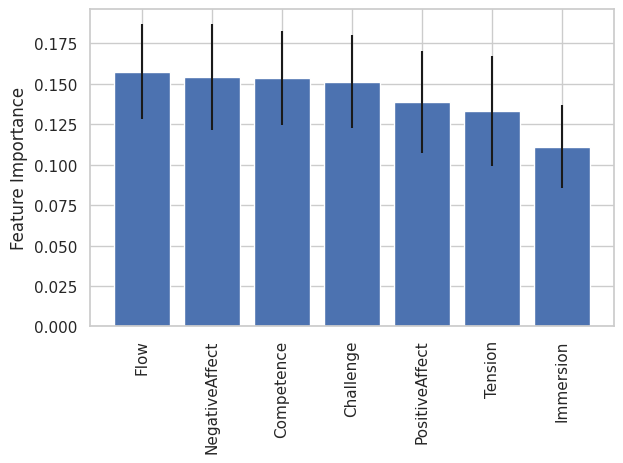

In [78]:
# Get the feature importances
importances = rf.feature_importances_

# Print the feature importances
for i, feature in enumerate(X_train.columns):
    print(f'{feature}: {importances[i]}')

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig, ax = plt.subplots()
ax.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align="center")
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(X_train.columns[indices], rotation=90)
ax.set_ylabel("Feature Importance")
plt.tight_layout()
plt.show()

In [79]:
#XGB
# Define the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          max_depth = 20,
                          alpha = 10,
                          n_estimators = 200,
                          random_state=42)
# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set using MAE as the scoring metric
cv_scores = -cross_val_score(xg_reg, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Display cross-validation MAE scores
print("Cross-validation MAE scores:", cv_scores)
print("Mean CV MAE:", cv_scores.mean())

# Train the XGBoost model on the full training set
xg_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xg_reg.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

# Evaluate the model performance on the test set using the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Cross-validation MAE scores: [0.22728048 0.24794774 0.24128161 0.23225207 0.24136927]
Mean CV MAE: 0.23802623237785653
RMSE: 0.270399
R2 score: 0.05337931273793051
Mean Absolute Error: 0.23062364621595902


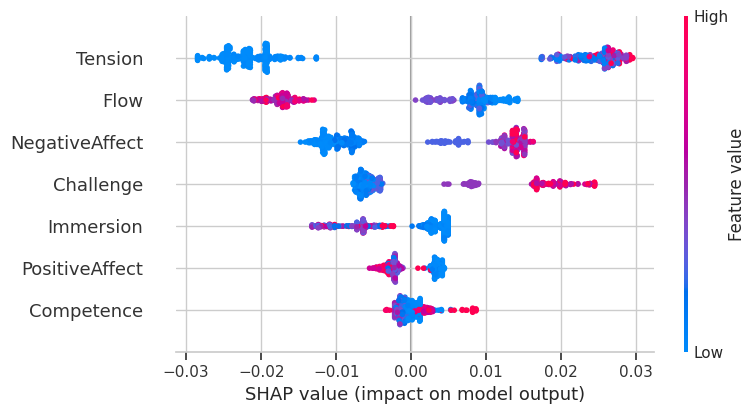

In [80]:
# Create a SHAP explainer object
explainer = shap.Explainer(xg_reg)

# Calculate the SHAP values for all the features
shap_values = explainer(X_train)

# Plot the SHAP values
shap.summary_plot(shap_values[:,:], X_train)

In [81]:
df = pd.read_excel('GameData.xlsx')

#Getting the right DF for inputs and labels
full_df = df.loc[:, ['NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow']]
labels = df.loc[:,['FinalPain_Intensity_0to200', 'Unpleasantness-0to100']]

#Data Normalization/Processesing

scaler = MinMaxScaler()

for column in labels.columns:
  scaler.fit(labels[[column]])
  labels[column] = scaler.transform(labels[[column]])

for column in ['NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow']:
  scaler.fit(full_df[[column]])
  full_df[column] = scaler.transform(full_df[[column]])

full_df
intensity = labels['FinalPain_Intensity_0to200']
unplea = labels['Unpleasantness-0to100']

In [82]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_df,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)



In [83]:
#LR
# Set up cross-validation

# Fit a linear regression model on the training data
model = LinearRegression()

# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Perform cross-validation on the training set
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
# Display cross-validation MAE scores
print("Cross-validation MAE scores:", -cv_scores)  # Negate the scores since cross_val_score returns negated values
print("Mean CV MAE:", -cv_scores.mean())

model.fit(X_train, y_train)

# Evaluate the model on the testing data
score = model.score(X_test, y_test)
print("R-squared score:", score)

y_pred = model.predict(X_test)

weights = model.coef_

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

Cross-validation MAE scores: [0.18419923 0.20320696 0.18282829 0.19150461 0.19520692]
Mean CV MAE: 0.19138920100487955
R-squared score: 0.05022672944701406
Mean Absolute Error: 0.19238699091006434
RMSE: 0.238095


In [84]:
# Create the Random Forest regression model with 100 trees
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set using MAE as the scoring metric
cv_scores = -cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Display cross-validation MAE scores
print("Cross-validation MAE scores:", cv_scores)
print("Mean CV MAE:", cv_scores.mean())
# Train the model on the training set
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model performance on the test set using the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Cross-validation MAE scores: [0.18712378 0.2010561  0.19112764 0.18836829 0.19097131]
Mean CV MAE: 0.191729424896708
R2 score: 0.02908188456742261
RMSE: 0.240250
Mean Absolute Error: 0.18911347402597406


NegativeAffect: 0.14336466477087811
PositiveAffect: 0.1314315078513403
Challenge: 0.15095090936426847
Tension: 0.13132936488507535
Immersion: 0.1149654188437579
Competence: 0.1635777366533725
Flow: 0.16438039763130724


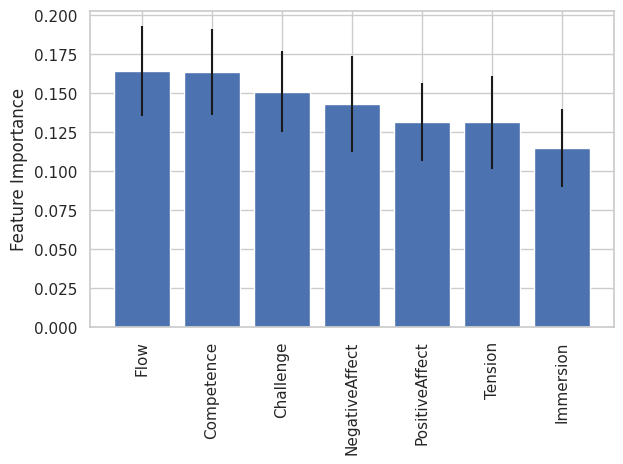

In [85]:
# Get the feature importances
importances = rf.feature_importances_

# Print the feature importances
for i, feature in enumerate(X_train.columns):
    print(f'{feature}: {importances[i]}')

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig, ax = plt.subplots()
ax.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align="center")
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(X_train.columns[indices], rotation=90)
ax.set_ylabel("Feature Importance")
plt.tight_layout()
plt.show()

In [86]:
#XGB
# Define the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          max_depth = 20,
                          alpha = 10,
                          n_estimators = 200,
                          random_state=42)
# Set up cross-validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set using MAE as the scoring metric
cv_scores = -cross_val_score(xg_reg, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Display cross-validation MAE scores
print("Cross-validation MAE scores:", cv_scores)
print("Mean CV MAE:", cv_scores.mean())

# Train the XGBoost model on the full training set
xg_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xg_reg.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

# Evaluate the model performance on the test set using the R2 score
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Cross-validation MAE scores: [0.18921879 0.20610771 0.19791064 0.19485965 0.20105052]
Mean CV MAE: 0.1978294610977173
RMSE: 0.238477
R2 score: 0.05078357458114624
Mean Absolute Error: 0.19357287883758545


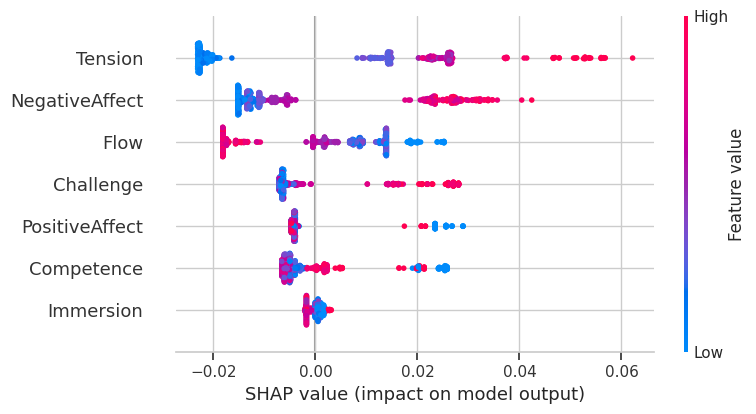

In [87]:
# Create a SHAP explainer object
explainer = shap.Explainer(xg_reg)

# Calculate the SHAP values for all the features
shap_values = explainer(X_train)

# Plot the SHAP values
shap.summary_plot(shap_values[:,:,1], X_train)

## Try to predict the games picked from the individual infos


In [88]:
df = pd.read_excel('GameData.xlsx')
# 2 participants don't havwe their data on which game is preferred and not


#Getting the right DF for inputs and labels
full_df = df.loc[:, ['BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total','Preffered Game Code','Least preffered Game Code']]

full_df = full_df.dropna()

#Data Normalization/Processesing
glp = full_df['Least preffered Game Code']
games = full_df['Preffered Game Code']

full_df = full_df.drop('Preffered Game Code', axis =1)
full_df = full_df.drop('Least preffered Game Code', axis =1)

scaler = MinMaxScaler()

for column in ['BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total']:
  scaler.fit(full_df[[column]])
  full_df[column] = scaler.transform(full_df[[column]])

'''
2048 -> 1
Drive and Park -> 2
Subway surfer -> 3
Tetris -> 4
Toon Blast -> 5
Flow Free -> 6

Fast = 2,3,4
Slow = 1,5,6
'''

'\n2048 -> 1\nDrive and Park -> 2\nSubway surfer -> 3\nTetris -> 4\nToon Blast -> 5\nFlow Free -> 6\n\nFast = 2,3,4\nSlow = 1,5,6\n'

In [89]:
clean_df = full_df.drop_duplicates()
clean_games = games.iloc[::12]
clean_games = clean_games - 1
clean_glp = glp.iloc[::12]
clean_glp = clean_glp - 1

replacement_mapping = {1: 0, 2: 0, 3: 0, 0: 1, 4: 1, 5: 1} #0 is Fast, 1 is slow
clean_cat_games = clean_games.replace(replacement_mapping)
clean_cat_glp = clean_glp.replace(replacement_mapping)

In [90]:
clean_games.value_counts()

,count
Preffered Game Code,
2.0,35
5.0,11
0.0,9
3.0,3
4.0,2
1.0,2


In [91]:
clean_glp.value_counts()

,count
Least preffered Game Code,
1.0,21
4.0,20
3.0,15
0.0,5
5.0,1


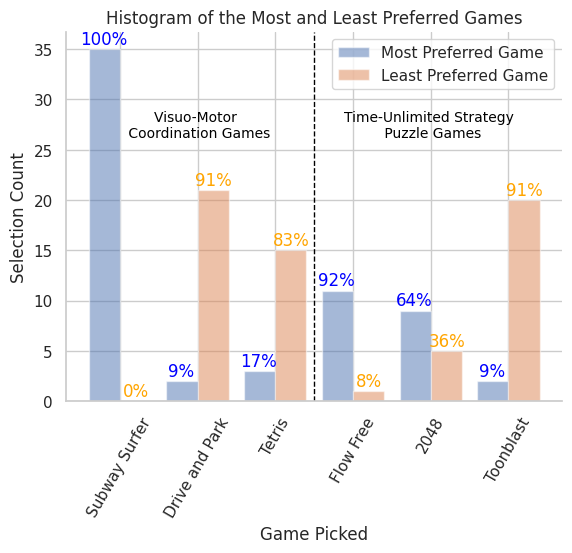

In [92]:
# Assuming clean_games and clean_glp are your Pandas Series
clean_games_values = clean_games.dropna().astype(int).map({0: 4, 1: 1, 2: 0, 3: 2, 4: 5, 5: 3})  # Map the values
clean_glp_values = clean_glp.dropna().astype(int).map({0: 4, 1: 1, 2: 0, 3: 2, 4: 5, 5: 3})  # Map the values

# Plotting histogram
n, bins, patches = plt.hist([clean_games_values, clean_glp_values], bins=range(7), alpha=0.5, label=['Most Preferred Game', 'Least Preferred Game'])

# Adjusting x-axis ticks to be in the middle of each pair of bars
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
plt.xticks(bin_centers, ['Subway Surfer', 'Drive and Park', 'Tetris', 'Flow Free', '2048', 'Toonblast' ], rotation = 60)

# Adding proportions on top of the bars

for i in range(len(bin_centers)):
    # Adding percentages for Preferred Game
    percentage_games = (n[0][i] / (n[0][i]+n[1][i])) * 100
    plt.text(bin_centers[i] - 0.21, n[0][i] + 0.5, f'{percentage_games:.0f}%', ha='center', color='blue')

    # Adding percentages for Least Preferred Game
    percentage_glp = (n[1][i] / (n[0][i]+n[1][i])) * 100
    plt.text(bin_centers[i] + 0.21, n[1][i] + 0.5, f'{percentage_glp:.0f}%', ha='center', color='orange')

# Adding dashed line to separate first three categories from the last three
plt.axvline(x=3, color='black', linestyle='--', linewidth=1)

# Adding text on middle-left and middle-right parts
plt.text(1.5, max(max(n[0]), max(n[1])) * 0.75, 'Visuo-Motor \n Coordination Games', fontsize=10, ha='center', color='black')
plt.text(4.5, max(max(n[0]), max(n[1])) * 0.75, 'Time-Unlimited Strategy \n Puzzle Games', fontsize=10, ha='center', color='black')

ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding labels and title
plt.xlabel('Game Picked')
plt.ylabel('Selection Count')
plt.title('Histogram of the Most and Least Preferred Games')
plt.legend()

# Display the histogram
plt.show()

In [93]:
from scipy.stats import chi2_contingency

# Define the subgroups for both clean_games_values and clean_glp_values
group_1_clean_games = clean_games_values[clean_games_values.isin([0, 1, 2])].count()  # Group 0, 1, 2
group_2_clean_games = clean_games_values[clean_games_values.isin([3, 4, 5])].count()  # Group 3, 4, 5

group_1_clean_glp = clean_glp_values[clean_glp_values.isin([0, 1, 2])].count()  # Group 0, 1, 2
group_2_clean_glp = clean_glp_values[clean_glp_values.isin([3, 4, 5])].count()  # Group 3, 4, 5

# Create the contingency table
contingency_table = np.array([[group_1_clean_games, group_2_clean_games],
                              [group_1_clean_glp, group_2_clean_glp]])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f'Chi-Square Value: {chi2}')
print(f'P-Value: {p}')
print(f'Degrees of Freedom: {dof}')
print(f'Expected Counts: \n{expected}')


Chi-Square Value: 0.3059210526315789
P-Value: 0.5801940437176559
Degrees of Freedom: 1
Expected Counts: 
[[38. 24.]
 [38. 24.]]


In [94]:
print(contingency_table)

[[40 22]
 [36 26]]


In [95]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(clean_df,
                                                    clean_glp,
                                                    test_size=0.2,
                                                    random_state=42)



In [96]:
df.columns

Index(['SubjectID', 'ConditionType', 'TrialType', 'FinalTrialType',
       'Trial numbers ', 'Pain_Intensity_100to200', 'Warm_Intensity-0-100',
       'FinalPain_Intensity_0to200', 'Unpleasantness-0to100', 'NegativeAffect',
       'PositiveAffect', 'Challenge', 'Tension', 'Immersion', 'Competence',
       'Flow', 'D1_LR', 'D2_LR', 'D3_LR', 'D1_G-P', 'D2_G-P', 'D3_G-P',
       'BFI-Extraversion', 'BFI-Agreeableness', 'BFI-Conscientiousness',
       'BFI-Neuroticism', 'BFI-Openness', 'PCS Total ', 'PCS Rumination',
       'PCS Magnification', 'PCS Helplessness', 'FFMQ-Observing',
       'FFMQ-Describing', 'FFMQ-Acting with Awareness',
       'FFMQ-Nonjudging of inner experience',
       'FFMQ-Nonreactivity to inner experience', 'FFMQ Total',
       'Preffered Game name ', 'Least preffered Game name ',
       'Preffered Game Code', 'Least preffered Game Code',
       'Order of task (1, 2, 3)', 'Trial numbers .1', 'Trial Name '],
      dtype='object')

In [97]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# Deep Neural Network with TensorFlow/Keras
input_dim = X_train.shape[1]

# Define the DNN model
dnn_model = Sequential([
    Dense(64, input_dim=input_dim, activation='relu'),
    Dense(32, activation='relu'),
    Dense(6, activation='softmax')  # Adjust the number of classes
])

# Compile the model
dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
dnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model on the test set
dnn_loss, dnn_accuracy = dnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Deep Neural Network Accuracy: {dnn_accuracy:.4f}")

Random Forest Accuracy: 0.5385
Logistic Regression Accuracy: 0.5385


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep Neural Network Accuracy: 0.4615


In [98]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(clean_df,
                                                    clean_cat_glp,
                                                    test_size=0.2,
                                                    random_state=42)


In [99]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# Deep Neural Network with TensorFlow/Keras
input_dim = X_train.shape[1]

# Define the DNN model
dnn_model = Sequential([
    Dense(64, input_dim=input_dim, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # Adjust the number of classes
])

# Compile the model
dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
dnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model on the test set
dnn_loss, dnn_accuracy = dnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Deep Neural Network Accuracy: {dnn_accuracy:.4f}")

Random Forest Accuracy: 0.6154
Logistic Regression Accuracy: 0.5385


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep Neural Network Accuracy: 0.6154


In [100]:
X_test.shape

(13, 14)